Loading UCI-HAR dataset...
Loaded all data: X=(10299, 9, 128), y=(10299,), Subjects=30

Starting comprehensive subject analysis...

SUBJECT-WISE DATA DISTRIBUTION ANALYSIS

1. Creating activity distribution plots...


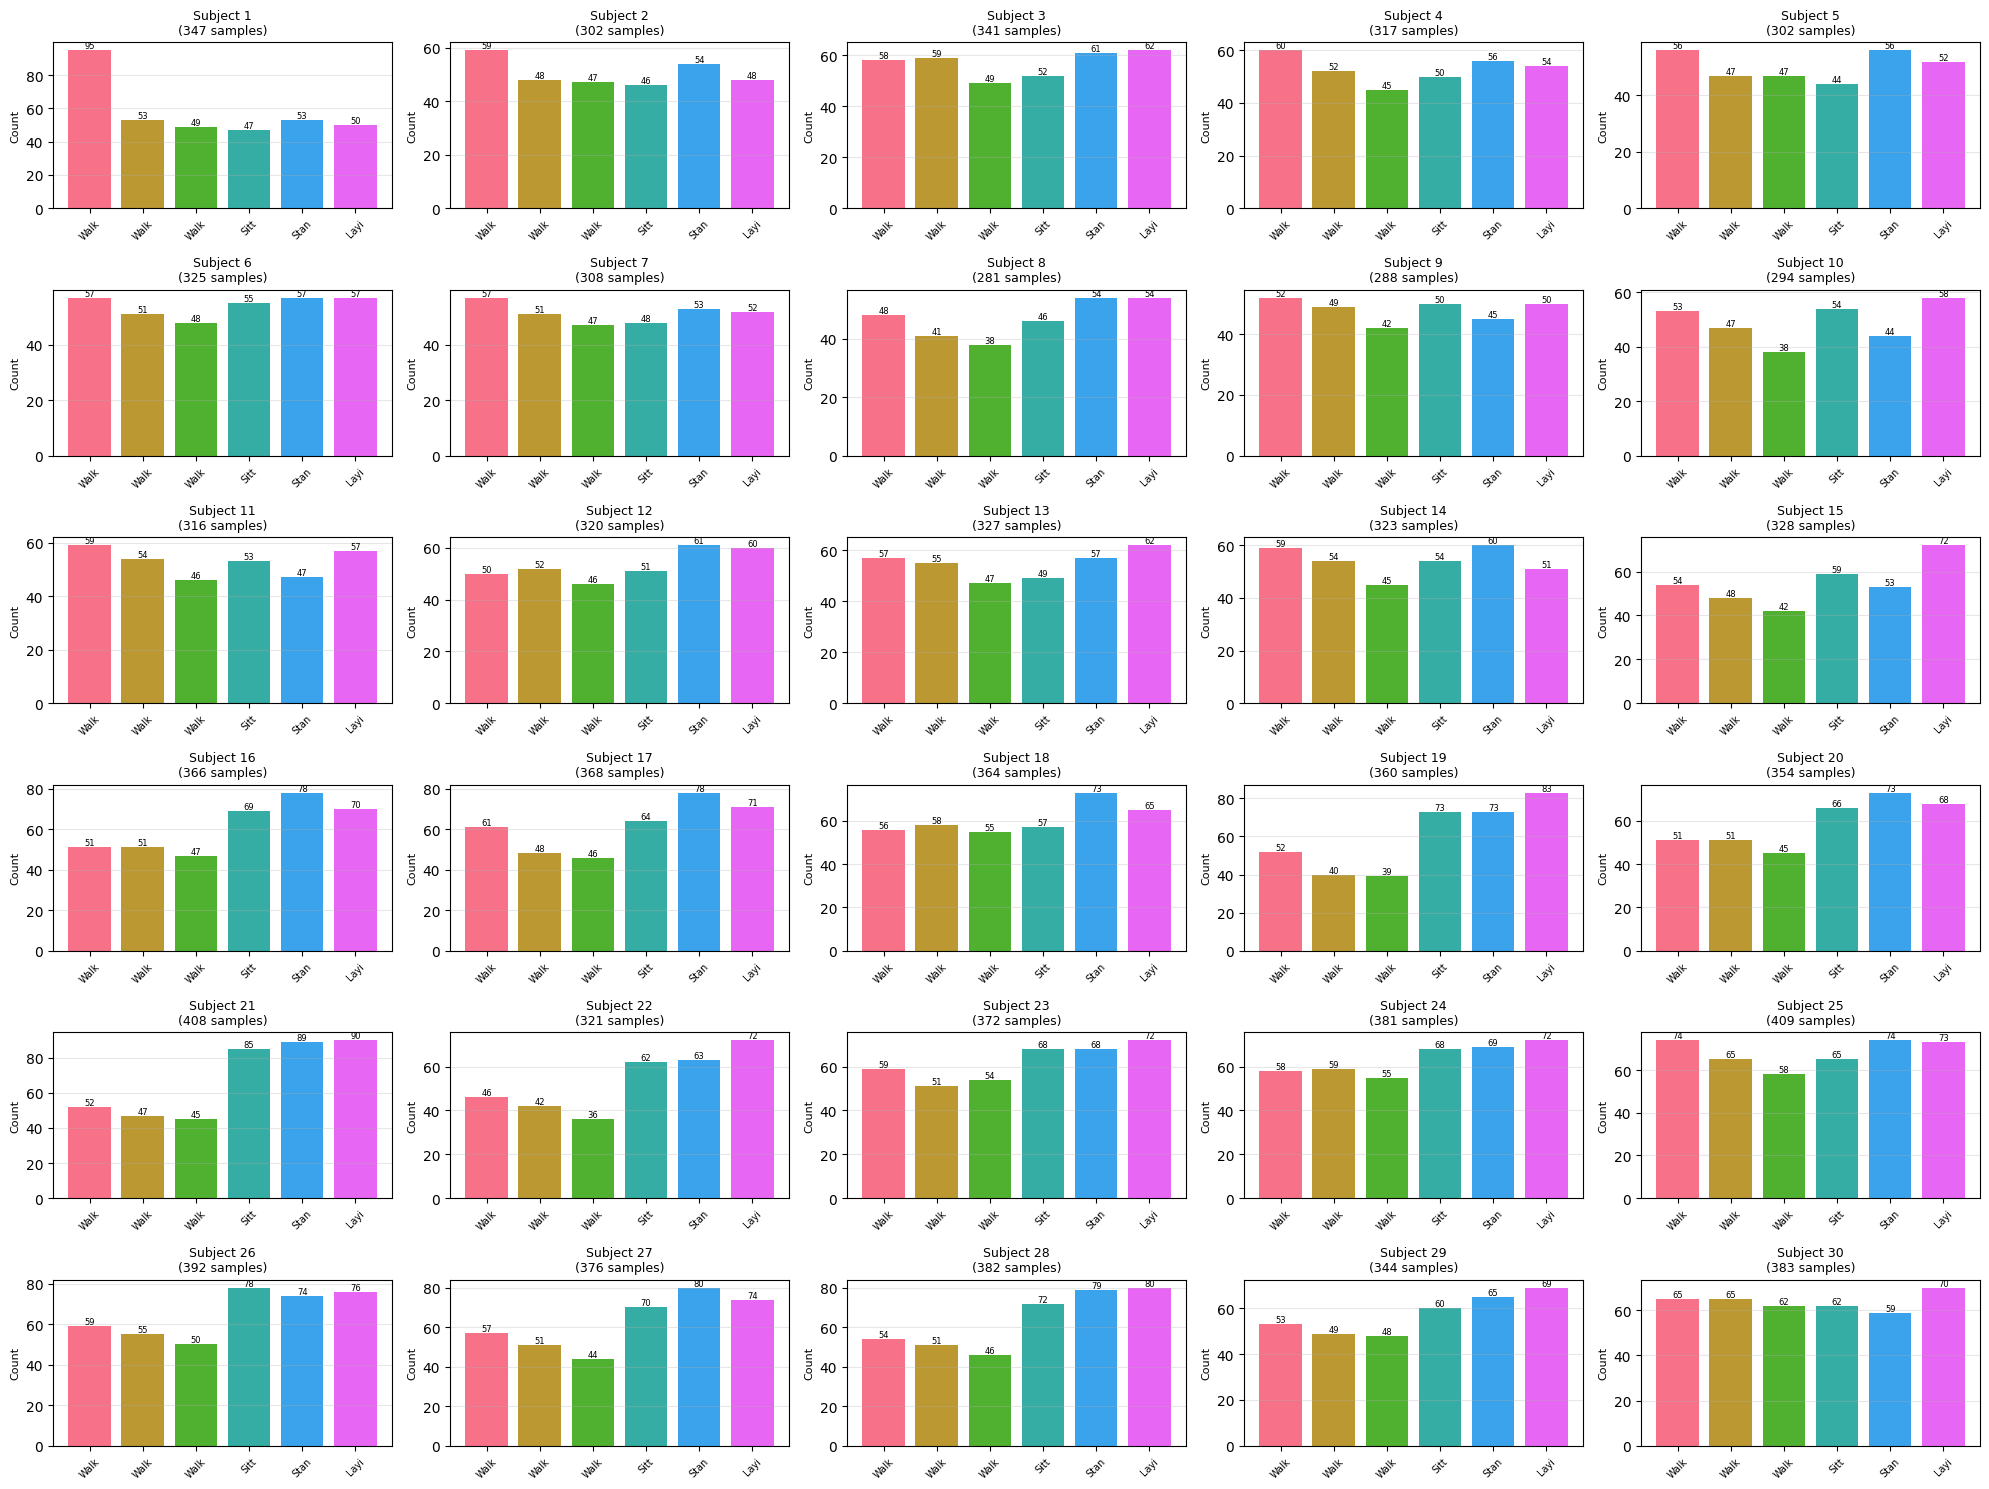

   Saved: ./subject_activity_distribution.png

2. Creating sensor signal statistics...


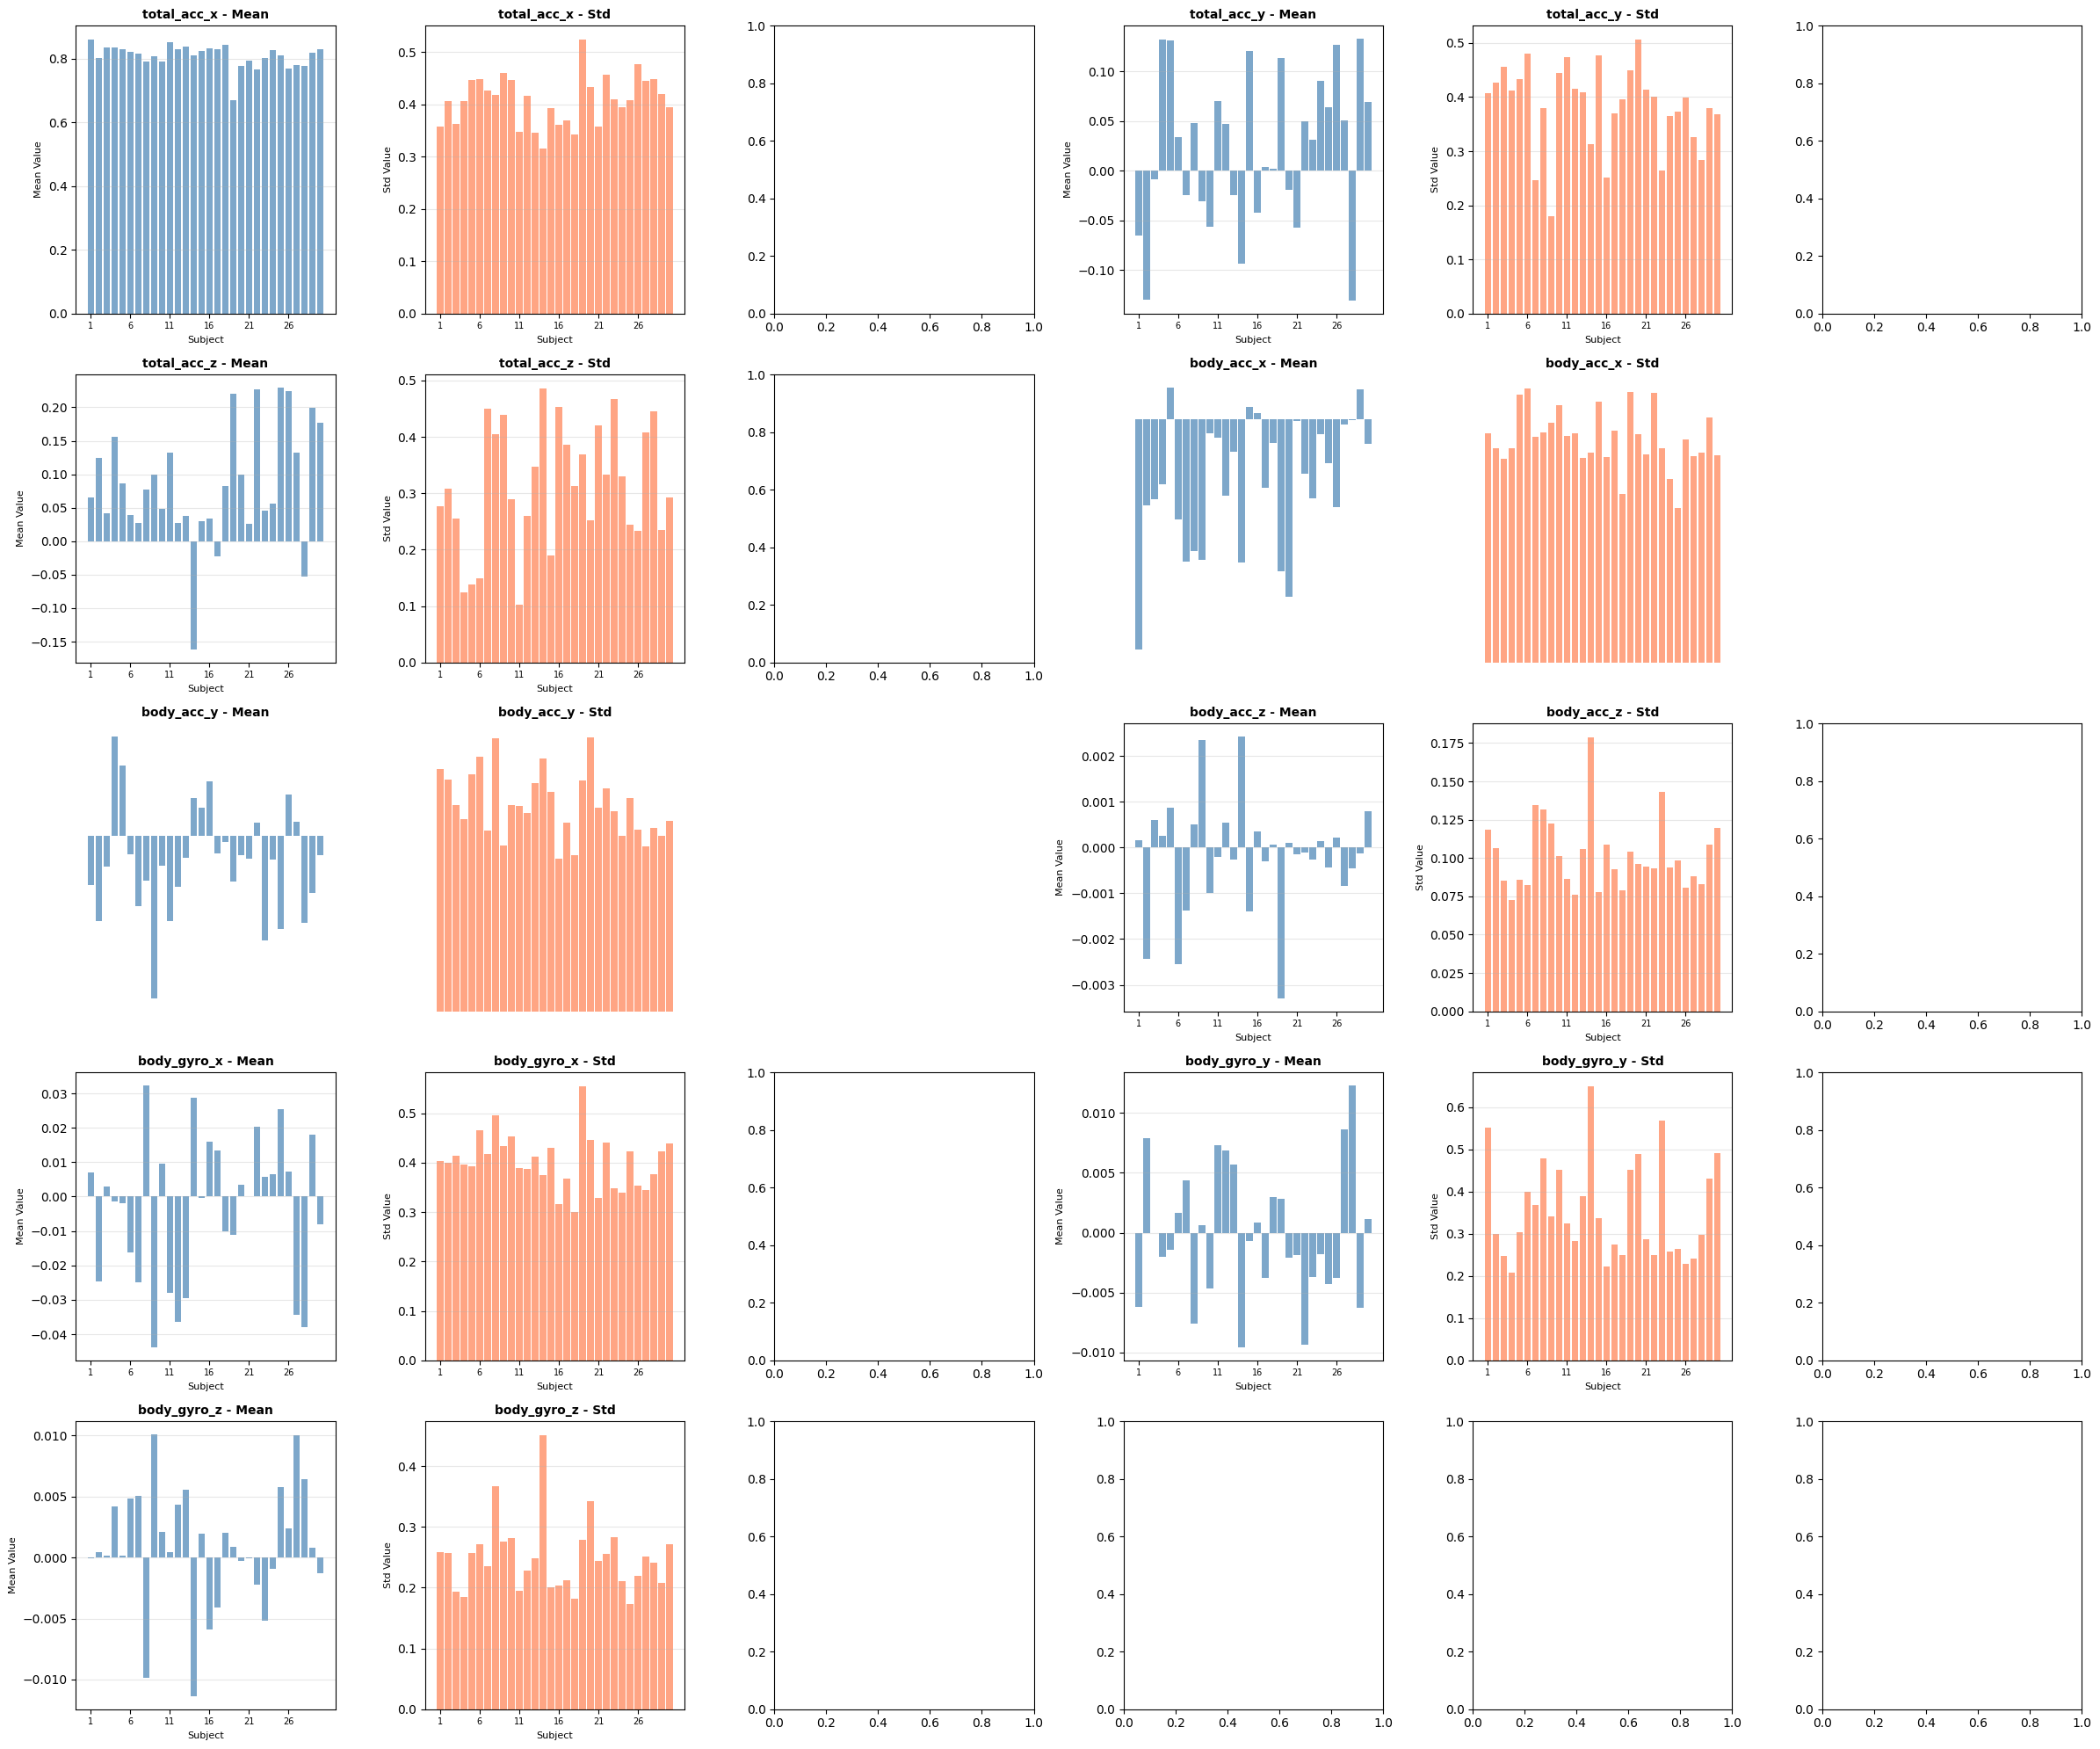

   Saved: ./subject_signal_statistics.png

3. Creating subject similarity heatmap (PCA-based)...


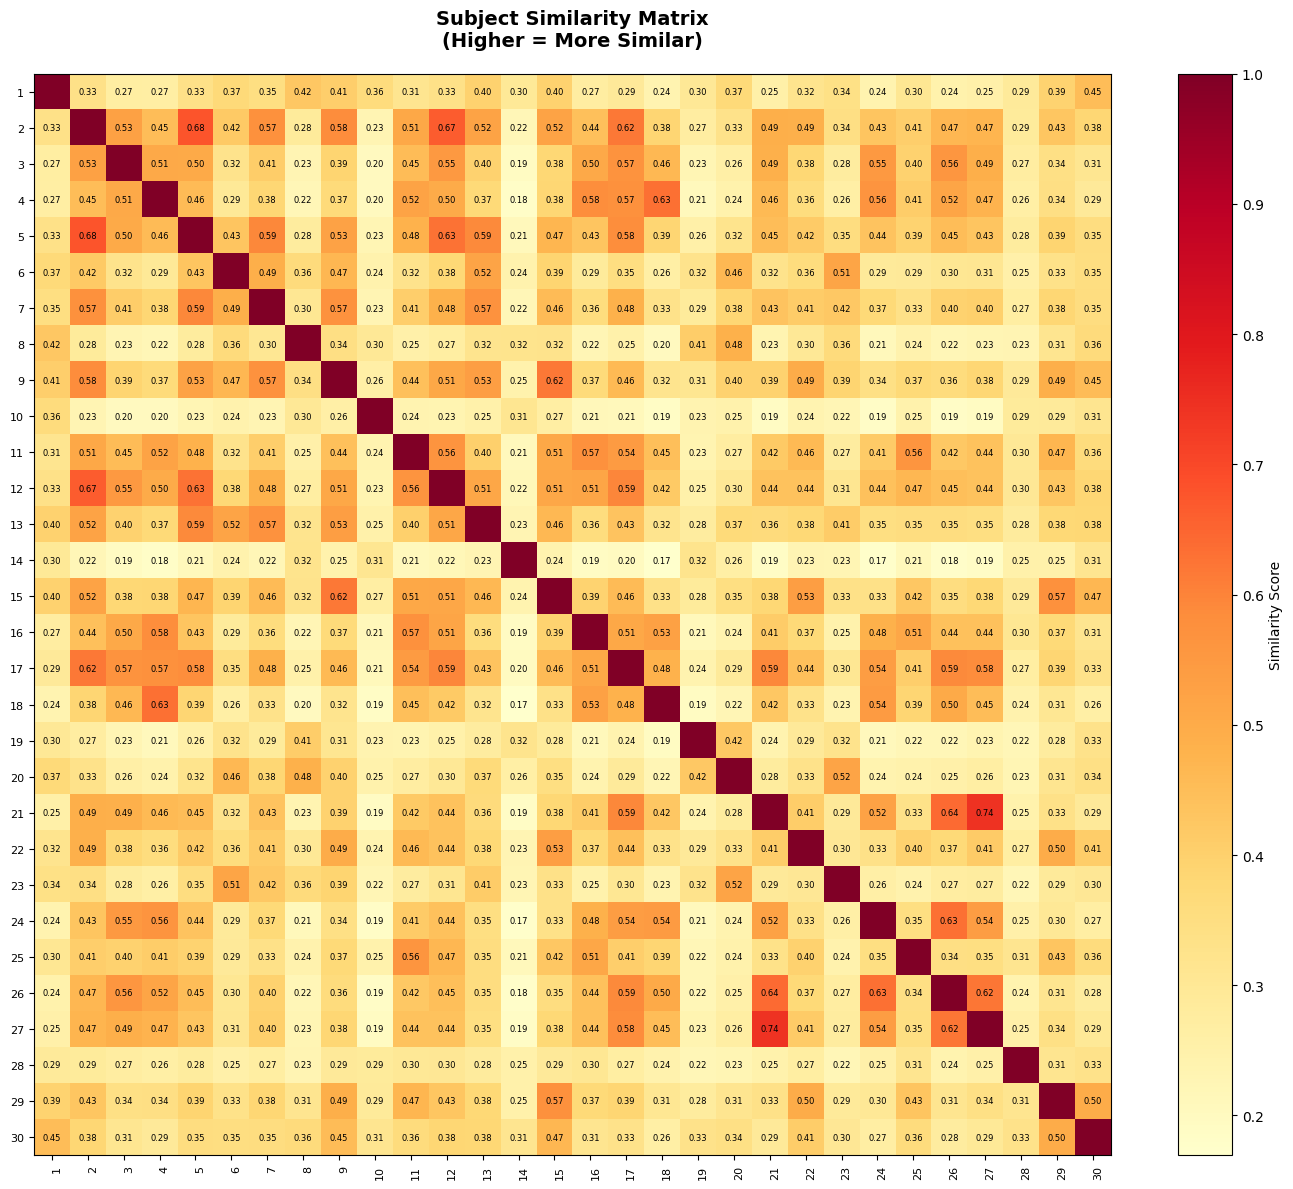

   Saved: ./subject_similarity_heatmap.png

4. Creating t-SNE visualization of subjects...
   Running t-SNE (this may take a minute)...


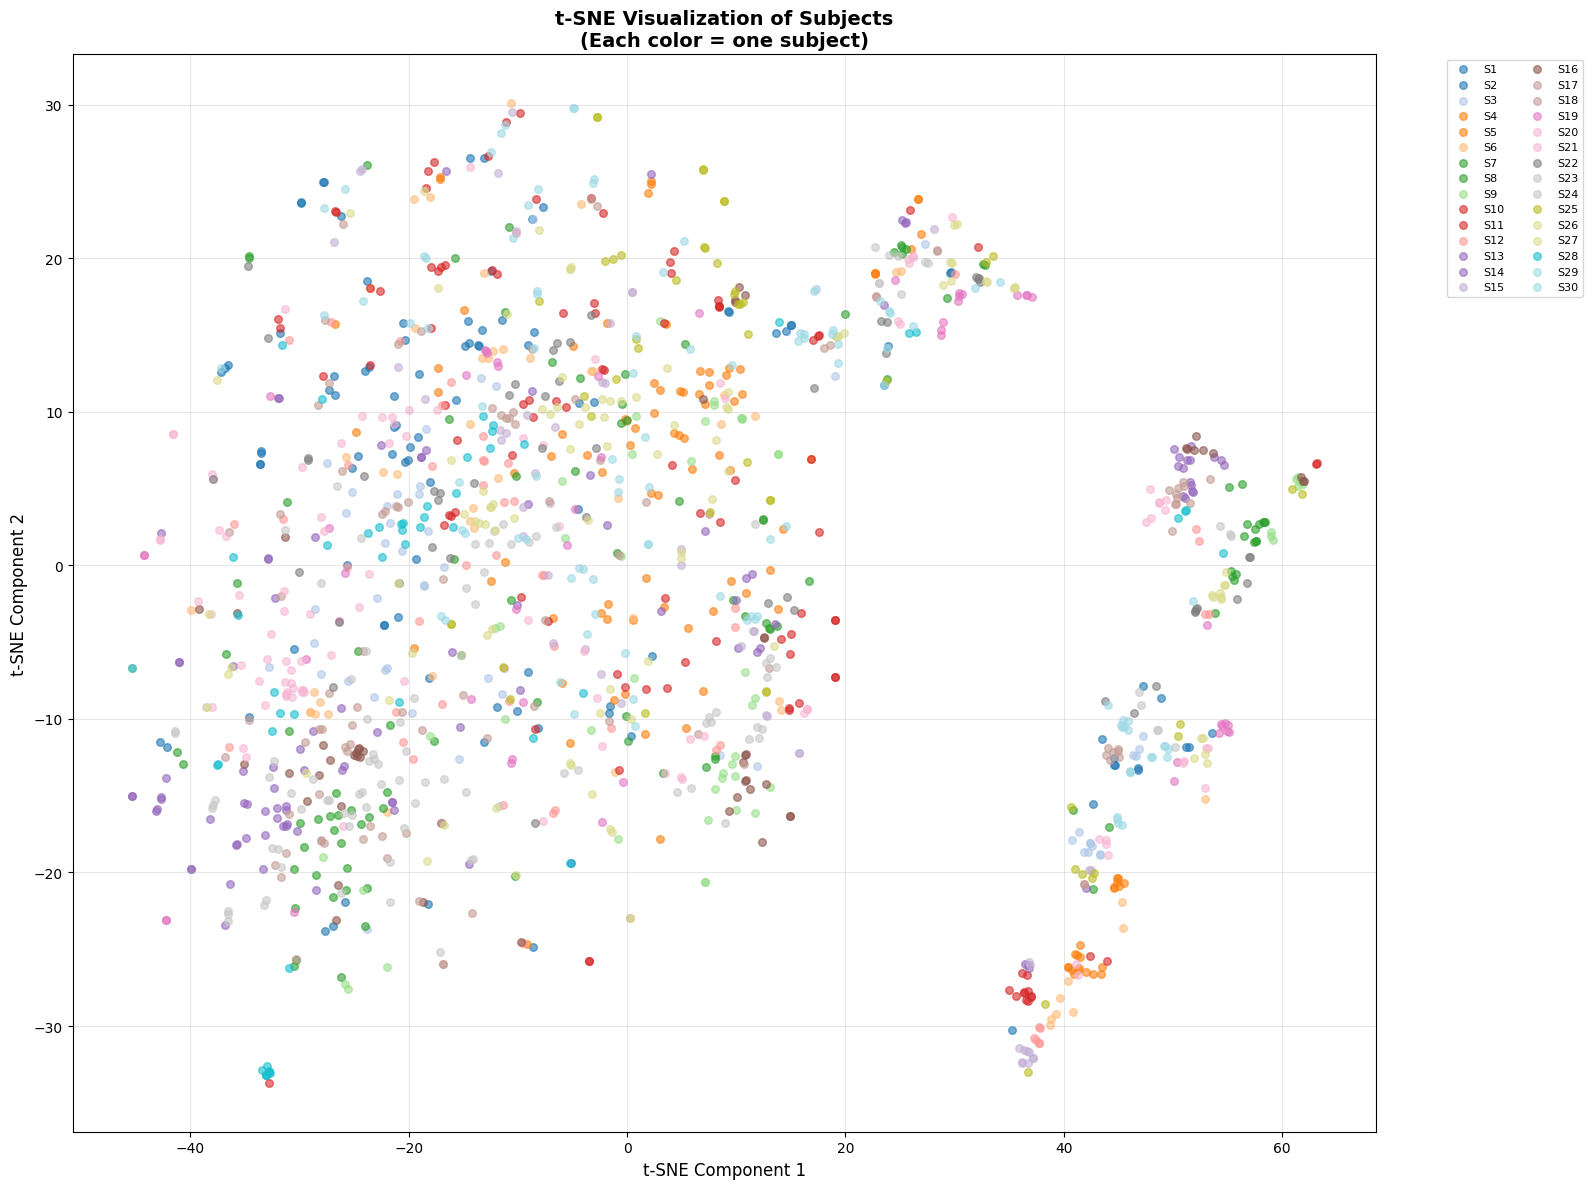

   Saved: ./subject_tsne_visualization.png

5. Creating activity balance comparison...


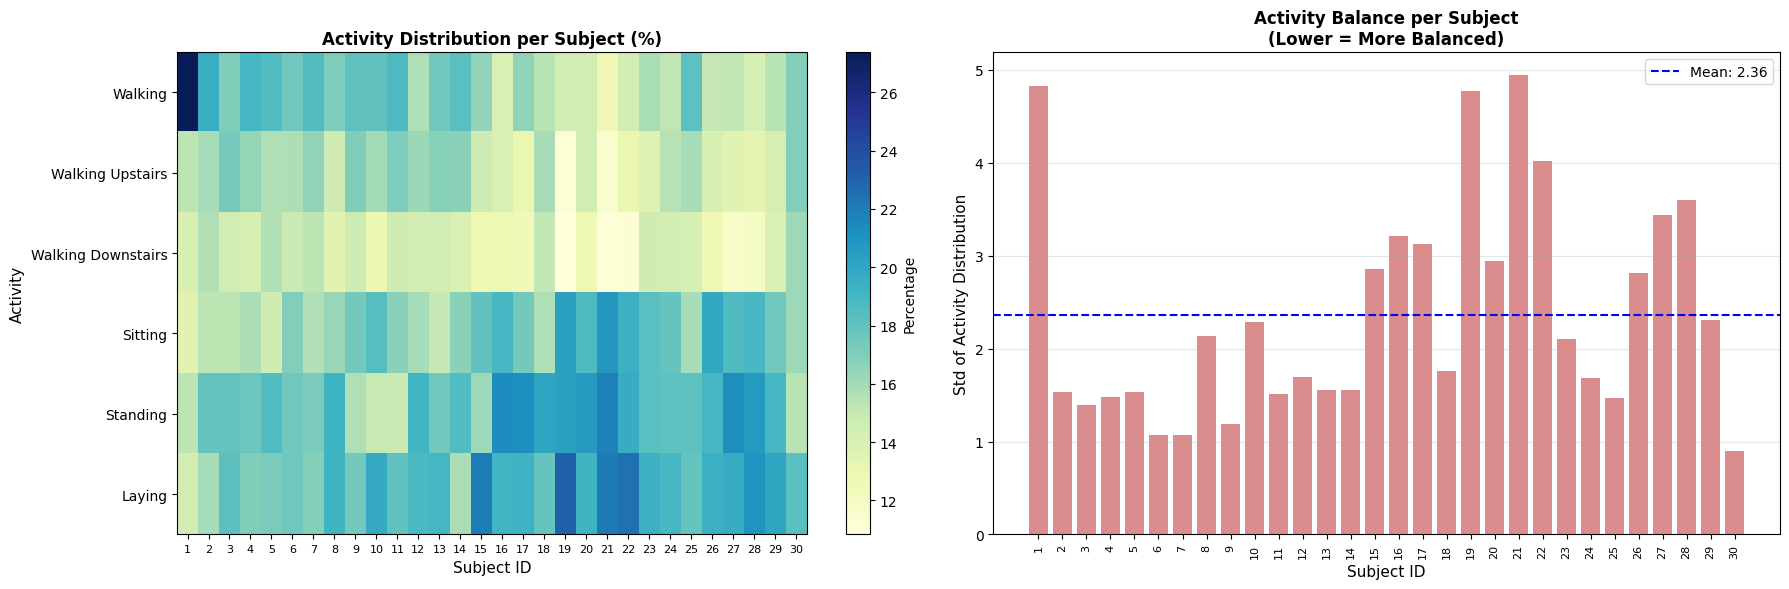

   Saved: ./subject_activity_balance.png

RECOMMENDATIONS FOR TRAIN/TEST SPLIT

📊 Subject Statistics Summary:
 Subject  Total_Samples  Activity_Balance_Std  Avg_Similarity
       2            302              1.537350        0.458182
      17            368              3.120731        0.452192
      12            320              1.689299        0.450353
       5            302              1.537350        0.444055
       9            288              1.185990        0.435952
      15            328              2.858203        0.426622
      11            316              1.513998        0.426538
       7            308              1.071374        0.421322
      13            327              1.556832        0.413344
       3            341              1.390172        0.413296
       4            317              1.484290        0.408904
      21            408              4.942642        0.408278
      27            376              3.432351        0.406825
      26            39

In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

def read_txt_matrix(path: str) -> np.ndarray:
    return np.loadtxt(path, dtype=np.float32)

def load_full_uci_har_data(root: str):
    UCI_CHANNELS_PREFIX = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    ]
    def load_split(split):
        channels = [read_txt_matrix(os.path.join(root, f"{prefix}{split}.txt")) for prefix in UCI_CHANNELS_PREFIX]
        X = np.stack(channels, axis=1)
        y = read_txt_matrix(os.path.join(root, f"y_{split}.txt")).astype(int) - 1
        subjects = read_txt_matrix(os.path.join(root, f"subject_{split}.txt")).astype(int)
        return X, y, subjects

    X_train, y_train, subjects_train = load_split("train")
    X_test, y_test, subjects_test = load_split("test")

    X_all = np.concatenate((X_train, X_test), axis=0)
    y_all = np.concatenate((y_train, y_test), axis=0)
    subjects_all = np.concatenate((subjects_train, subjects_test), axis=0)

    sorted_indices = np.argsort(subjects_all)
    X_all, y_all, subjects_all = X_all[sorted_indices], y_all[sorted_indices], subjects_all[sorted_indices]

    activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    print(f"Loaded all data: X={X_all.shape}, y={y_all.shape}, Subjects={len(np.unique(subjects_all))}")
    return X_all, y_all, subjects_all, activity_names

def analyze_subject_distribution(X_all, y_all, subjects_all, activity_names):
    unique_subjects = np.unique(subjects_all)
    n_subjects = len(unique_subjects)

    print("\n" + "="*80)
    print("SUBJECT-WISE DATA DISTRIBUTION ANALYSIS")
    print("="*80)

    subject_info = []
    for subj in unique_subjects:
        mask = subjects_all == subj
        X_subj = X_all[mask]
        y_subj = y_all[mask]

        activity_counts = np.bincount(y_subj, minlength=6)
        total_samples = len(y_subj)

        mean_signal = X_subj.mean(axis=(0, 2))
        std_signal = X_subj.std(axis=(0, 2))

        subject_info.append({
            'subject': subj,
            'total_samples': total_samples,
            'activity_counts': activity_counts,
            'mean_signal': mean_signal,
            'std_signal': std_signal,
            'X': X_subj,
            'y': y_subj
        })

    fig = plt.figure(figsize=(20, 15))

    print("\n1. Creating activity distribution plots...")
    for idx, info in enumerate(subject_info):
        ax = plt.subplot(6, 5, idx + 1)
        counts = info['activity_counts']
        bars = ax.bar(range(6), counts, color=sns.color_palette("husl", 6))
        ax.set_title(f"Subject {info['subject']}\n({info['total_samples']} samples)", fontsize=9)
        ax.set_xticks(range(6))
        ax.set_xticklabels([a[:4] for a in activity_names], rotation=45, fontsize=7)
        ax.set_ylabel('Count', fontsize=8)
        ax.grid(axis='y', alpha=0.3)

        for bar, count in zip(bars, counts):
            height = bar.get_height()
            if count > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(count)}', ha='center', va='bottom', fontsize=6)

    plt.tight_layout()
    plt.savefig('./subject_activity_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   Saved: ./subject_activity_distribution.png")

    print("\n2. Creating sensor signal statistics...")
    fig, axes = plt.subplots(5, 6, figsize=(24, 20))

    channel_names = ['total_acc_x', 'total_acc_y', 'total_acc_z',
                     'body_acc_x', 'body_acc_y', 'body_acc_z',
                     'body_gyro_x', 'body_gyro_y', 'body_gyro_z']

    for ch_idx in range(9):
        ax_mean = axes[ch_idx // 2, (ch_idx % 2) * 3]
        ax_std = axes[ch_idx // 2, (ch_idx % 2) * 3 + 1]

        means = [info['mean_signal'][ch_idx] for info in subject_info]
        stds = [info['std_signal'][ch_idx] for info in subject_info]
        subjects = [info['subject'] for info in subject_info]

        ax_mean.bar(range(len(subjects)), means, color='steelblue', alpha=0.7)
        ax_mean.set_title(f'{channel_names[ch_idx]} - Mean', fontsize=10, fontweight='bold')
        ax_mean.set_xlabel('Subject', fontsize=8)
        ax_mean.set_ylabel('Mean Value', fontsize=8)
        ax_mean.grid(axis='y', alpha=0.3)
        ax_mean.set_xticks(range(0, len(subjects), 5))
        ax_mean.set_xticklabels([subjects[i] for i in range(0, len(subjects), 5)], fontsize=7)

        ax_std.bar(range(len(subjects)), stds, color='coral', alpha=0.7)
        ax_std.set_title(f'{channel_names[ch_idx]} - Std', fontsize=10, fontweight='bold')
        ax_std.set_xlabel('Subject', fontsize=8)
        ax_std.set_ylabel('Std Value', fontsize=8)
        ax_std.grid(axis='y', alpha=0.3)
        ax_std.set_xticks(range(0, len(subjects), 5))
        ax_std.set_xticklabels([subjects[i] for i in range(0, len(subjects), 5)], fontsize=7)

    for i in range(9, 15):
        axes.flat[i].axis('off')

    plt.tight_layout()
    plt.savefig('./subject_signal_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   Saved: ./subject_signal_statistics.png")

    print("\n3. Creating subject similarity heatmap (PCA-based)...")
    subject_features = []
    for info in subject_info:
        X_flat = info['X'].reshape(len(info['X']), -1)
        pca = PCA(n_components=50)
        X_pca = pca.fit_transform(X_flat)
        feature_vector = np.concatenate([
            X_pca.mean(axis=0),
            X_pca.std(axis=0),
            info['activity_counts'] / info['activity_counts'].sum()
        ])
        subject_features.append(feature_vector)

    subject_features = np.array(subject_features)

    from scipy.spatial.distance import pdist, squareform
    distances = pdist(subject_features, metric='euclidean')
    distance_matrix = squareform(distances)

    similarity_matrix = 1 / (1 + distance_matrix)

    fig, ax = plt.subplots(figsize=(14, 12))
    im = ax.imshow(similarity_matrix, cmap='YlOrRd', aspect='auto')

    ax.set_xticks(range(n_subjects))
    ax.set_yticks(range(n_subjects))
    ax.set_xticklabels([info['subject'] for info in subject_info], fontsize=8)
    ax.set_yticklabels([info['subject'] for info in subject_info], fontsize=8)

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    for i in range(n_subjects):
        for j in range(n_subjects):
            if i != j:
                text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                             ha="center", va="center", color="black", fontsize=6)

    ax.set_title("Subject Similarity Matrix\n(Higher = More Similar)", fontsize=14, fontweight='bold', pad=20)
    plt.colorbar(im, ax=ax, label='Similarity Score')
    plt.tight_layout()
    plt.savefig('./subject_similarity_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   Saved: ./subject_similarity_heatmap.png")

    print("\n4. Creating t-SNE visualization of subjects...")
    X_samples_per_subject = []
    y_subjects_label = []
    sample_limit = 50

    for info in subject_info:
        n_samples = min(sample_limit, len(info['X']))
        indices = np.random.choice(len(info['X']), n_samples, replace=False)
        X_samples = info['X'][indices].reshape(n_samples, -1)
        X_samples_per_subject.append(X_samples)
        y_subjects_label.extend([info['subject']] * n_samples)

    X_combined = np.vstack(X_samples_per_subject)

    print("   Running t-SNE (this may take a minute)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_combined)

    fig, ax = plt.subplots(figsize=(16, 12))

    colors = plt.cm.tab20(np.linspace(0, 1, n_subjects))

    for idx, subj in enumerate(unique_subjects):
        mask = np.array(y_subjects_label) == subj
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                  c=[colors[idx]], label=f'S{subj}', alpha=0.6, s=30)

    ax.set_title('t-SNE Visualization of Subjects\n(Each color = one subject)',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('t-SNE Component 1', fontsize=12)
    ax.set_ylabel('t-SNE Component 2', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('./subject_tsne_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   Saved: ./subject_tsne_visualization.png")

    print("\n5. Creating activity balance comparison...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    activity_by_subject = np.array([info['activity_counts'] for info in subject_info])
    activity_percentages = activity_by_subject / activity_by_subject.sum(axis=1, keepdims=True) * 100

    im1 = ax1.imshow(activity_percentages.T, cmap='YlGnBu', aspect='auto')
    ax1.set_yticks(range(6))
    ax1.set_yticklabels(activity_names, fontsize=10)
    ax1.set_xticks(range(n_subjects))
    ax1.set_xticklabels([info['subject'] for info in subject_info], fontsize=8)
    ax1.set_xlabel('Subject ID', fontsize=11)
    ax1.set_ylabel('Activity', fontsize=11)
    ax1.set_title('Activity Distribution per Subject (%)', fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=ax1, label='Percentage')

    activity_std = activity_percentages.std(axis=1)
    ax2.bar(range(n_subjects), activity_std, color='indianred', alpha=0.7)
    ax2.set_xlabel('Subject ID', fontsize=11)
    ax2.set_ylabel('Std of Activity Distribution', fontsize=11)
    ax2.set_title('Activity Balance per Subject\n(Lower = More Balanced)', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(n_subjects))
    ax2.set_xticklabels([info['subject'] for info in subject_info], fontsize=8, rotation=90)
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=activity_std.mean(), color='blue', linestyle='--',
               label=f'Mean: {activity_std.mean():.2f}')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('./subject_activity_balance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   Saved: ./subject_activity_balance.png")

    print("\n" + "="*80)
    print("RECOMMENDATIONS FOR TRAIN/TEST SPLIT")
    print("="*80)

    print("\n📊 Subject Statistics Summary:")
    summary_df = pd.DataFrame({
        'Subject': [info['subject'] for info in subject_info],
        'Total_Samples': [info['total_samples'] for info in subject_info],
        'Activity_Balance_Std': activity_std,
        'Avg_Similarity': similarity_matrix.mean(axis=1)
    })

    summary_df = summary_df.sort_values('Avg_Similarity', ascending=False)
    print(summary_df.to_string(index=False))
    summary_df.to_csv('./subject_statistics_summary.csv', index=False)
    print("\n   Saved: ./subject_statistics_summary.csv")

    print("\n💡 Recommendations:")
    print("\n1. GOOD TEST SUBJECTS (High similarity to others - easier to generalize):")
    top_similar = summary_df.nlargest(5, 'Avg_Similarity')
    for _, row in top_similar.iterrows():
        print(f"   Subject {int(row['Subject'])}: Similarity={row['Avg_Similarity']:.3f}, " +
              f"Samples={int(row['Total_Samples'])}, Balance={row['Activity_Balance_Std']:.2f}")

    print("\n2. CHALLENGING TEST SUBJECTS (Low similarity - harder to generalize):")
    bottom_similar = summary_df.nsmallest(5, 'Avg_Similarity')
    for _, row in bottom_similar.iterrows():
        print(f"   Subject {int(row['Subject'])}: Similarity={row['Avg_Similarity']:.3f}, " +
              f"Samples={int(row['Total_Samples'])}, Balance={row['Activity_Balance_Std']:.2f}")

    print("\n3. BALANCED TEST SUBJECTS (Good activity distribution):")
    balanced = summary_df.nsmallest(5, 'Activity_Balance_Std')
    for _, row in balanced.iterrows():
        print(f"   Subject {int(row['Subject'])}: Balance Std={row['Activity_Balance_Std']:.2f}, " +
              f"Samples={int(row['Total_Samples'])}")

    print("\n4. SUGGESTED TRAIN/TEST SPLITS:")

    highly_similar = summary_df[summary_df['Avg_Similarity'] > summary_df['Avg_Similarity'].median()]
    test_candidates = highly_similar.nlargest(9, 'Total_Samples')['Subject'].values

    print(f"\n   Option A (Recommended - Representative test set):")
    print(f"   Test subjects: {sorted([int(s) for s in test_candidates])}")

    very_dissimilar = summary_df.nsmallest(3, 'Avg_Similarity')['Subject'].values
    very_similar = summary_df.nlargest(6, 'Avg_Similarity')['Subject'].values
    test_candidates_b = np.concatenate([very_dissimilar, very_similar])[:9]
    print(f"\n   Option B (Challenging - Mix of easy and hard):")
    print(f"   Test subjects: {sorted([int(s) for s in test_candidates_b])}")

    most_balanced = summary_df.nsmallest(9, 'Activity_Balance_Std')['Subject'].values
    print(f"\n   Option C (Balanced activities):")
    print(f"   Test subjects: {sorted([int(s) for s in most_balanced])}")

    print("\n" + "="*80)
    print("Analysis complete! Check the generated PNG files for detailed visualizations.")
    print("="*80)

    return subject_info, similarity_matrix, summary_df

if __name__ == "__main__":
    dataset_root = "./"

    print("Loading UCI-HAR dataset...")
    X_all, y_all, subjects_all, activity_names = load_full_uci_har_data(dataset_root)

    print("\nStarting comprehensive subject analysis...")
    subject_info, similarity_matrix, summary_df = analyze_subject_distribution(
        X_all, y_all, subjects_all, activity_names
    )

Device: cuda
GPU: Tesla T4
Total GPU Memory: 15.83 GB
Loaded all data: X=(10299, 9, 128), y=(10299,), Subjects=30

ABLATION STUDY
Standard Train subjects: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 18, 19, 20, 22, 23, 24, 25, 28, 29, 30]
Standard Test subjects: [3, 12, 13, 15, 16, 17, 21, 26, 27]

################################################################################
# Running: 1_Baseline
################################################################################


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even


Results: 1_Baseline
Acc: 0.9058 | F1: 0.9106 | Prec: 0.9208 | Rec: 0.9102
Params: 0.02M | FLOPs: 0.47M | Inference: 0.27ms



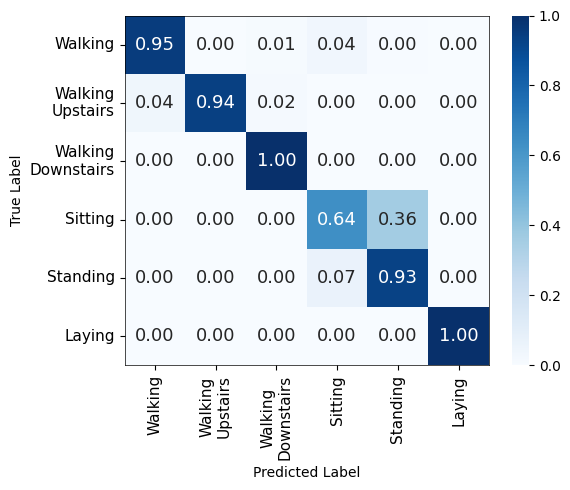


################################################################################
# Running: 2_Structure
################################################################################


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Results: 2_Structure
Acc: 0.9439 | F1: 0.9475 | Prec: 0.9518 | Rec: 0.9466
Params: 0.04M | FLOPs: 3.33M | Inference: 1.37ms



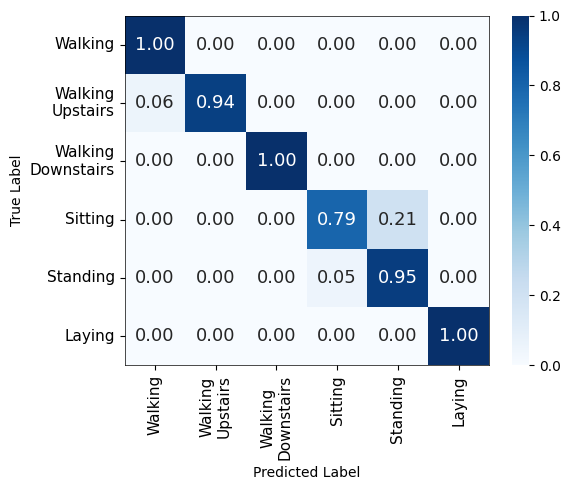


################################################################################
# Running: 3_Physics
################################################################################


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Results: 3_Physics
Acc: 0.9368 | F1: 0.9412 | Prec: 0.9470 | Rec: 0.9405
Params: 0.04M | FLOPs: 3.33M | Inference: 1.57ms



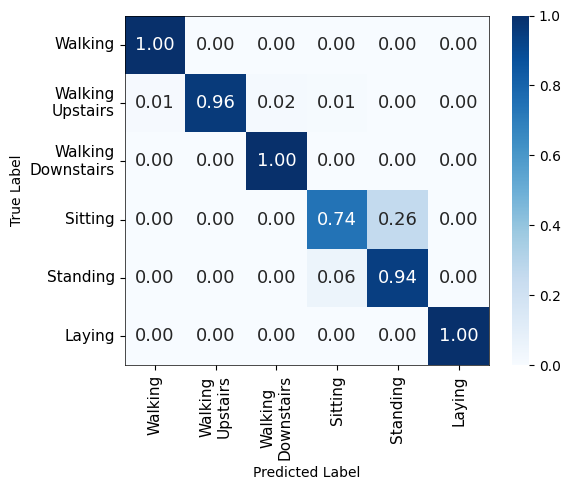

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



################################################################################
# Running: 4_Ours
################################################################################


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Results: 4_Ours
Acc: 0.9637 | F1: 0.9657 | Prec: 0.9666 | Rec: 0.9653
Params: 2.46M | FLOPs: 5.13M | Inference: 4.45ms



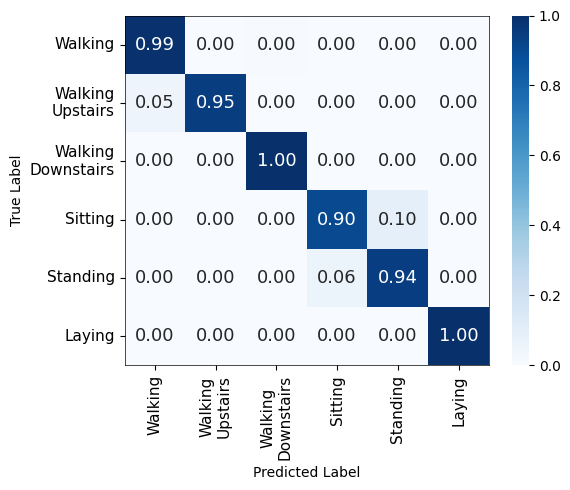


LEAVE-ONE-SUBJECT-OUT (LOSO)

--- LOSO Testing Subject 1 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9798, F1: 0.9757


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 1.0000, F1: 1.0000

--- LOSO Testing Subject 2 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.8841, F1: 0.8569


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9272, F1: 0.9194

--- LOSO Testing Subject 3 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9238, F1: 0.9199


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9707, F1: 0.9696

--- LOSO Testing Subject 4 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.7886, F1: 0.7755


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9054, F1: 0.9023

--- LOSO Testing Subject 5 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.8576, F1: 0.8558


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.8444, F1: 0.8215

--- LOSO Testing Subject 6 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9015, F1: 0.8978


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9446, F1: 0.9447

--- LOSO Testing Subject 7 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9156, F1: 0.9146


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9253, F1: 0.9237

--- LOSO Testing Subject 8 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.8754, F1: 0.8670


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9324, F1: 0.9359

--- LOSO Testing Subject 9 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.7188, F1: 0.7137


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8146b6dda0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8146b6dda0> 
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^if w.is_alive():^
^^^^ ^ 
  File 

  Ours -> Acc: 0.7882, F1: 0.7818

--- LOSO Testing Subject 10 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8146b6dda0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shu

  Baseline -> Acc: 0.6156, F1: 0.6136


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8146b6dda0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^Exception ignored in: 
^    ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d8146b6dda0>^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 166

  Ours -> Acc: 0.7245, F1: 0.7414

--- LOSO Testing Subject 11 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8146b6dda0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shu

  Baseline -> Acc: 1.0000, F1: 1.0000


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8146b6dda0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8146b6dda0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.

  Ours -> Acc: 1.0000, F1: 1.0000

--- LOSO Testing Subject 12 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9969, F1: 0.9970


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9875, F1: 0.9880

--- LOSO Testing Subject 13 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9572, F1: 0.9545


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9664, F1: 0.9650

--- LOSO Testing Subject 14 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.6904, F1: 0.6564


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.7121, F1: 0.6720

--- LOSO Testing Subject 15 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9390, F1: 0.9334


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 1.0000, F1: 1.0000

--- LOSO Testing Subject 16 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.7077, F1: 0.7443


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.7049, F1: 0.7422

--- LOSO Testing Subject 17 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9592, F1: 0.9633


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9674, F1: 0.9709

--- LOSO Testing Subject 18 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9011, F1: 0.8909


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9945, F1: 0.9940

--- LOSO Testing Subject 19 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.8944, F1: 0.9061


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9361, F1: 0.9431

--- LOSO Testing Subject 20 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.8333, F1: 0.8047


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9944, F1: 0.9952

--- LOSO Testing Subject 21 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.8456, F1: 0.8583


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9020, F1: 0.9181

--- LOSO Testing Subject 22 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9252, F1: 0.9033


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 1.0000, F1: 1.0000

--- LOSO Testing Subject 23 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9651, F1: 0.9620


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9489, F1: 0.9518

--- LOSO Testing Subject 24 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9974, F1: 0.9970


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 1.0000, F1: 1.0000

--- LOSO Testing Subject 25 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9169, F1: 0.9175


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9022, F1: 0.9001

--- LOSO Testing Subject 26 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9337, F1: 0.9379


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 1.0000, F1: 1.0000

--- LOSO Testing Subject 27 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9521, F1: 0.9573


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 1.0000, F1: 1.0000

--- LOSO Testing Subject 28 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.8848, F1: 0.8888


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.8089, F1: 0.8398

--- LOSO Testing Subject 29 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.9070, F1: 0.9103


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9128, F1: 0.9167

--- LOSO Testing Subject 30 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even

  Baseline -> Acc: 0.8956, F1: 0.8939


/tmp/ipython-input-1811355576.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  Ours -> Acc: 0.9112, F1: 0.9057

NOISE ROBUSTNESS TEST - UNIFORM

Testing Uniform Noise Level: 5%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.9089, F1: 0.9117
  Baseline-> Acc: 0.9269, F1: 0.9229

Testing Uniform Noise Level: 10%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8831, F1: 0.8824
  Baseline-> Acc: 0.9634, F1: 0.9607

Testing Uniform Noise Level: 15%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8729, F1: 0.8695
  Baseline-> Acc: 0.9504, F1: 0.9459

Testing Uniform Noise Level: 20%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8689, F1: 0.8640
  Baseline-> Acc: 0.9347, F1: 0.9272

Testing Uniform Noise Level: 30%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8543, F1: 0.8452
  Baseline-> Acc: 0.8851, F1: 0.8573

Testing Uniform Noise Level: 50%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.6699, F1: 0.6377
  Baseline-> Acc: 0.8433, F1: 0.7772

NOISE ROBUSTNESS TEST - GAUSSIAN

Testing Gaussian Noise Level: 5%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8862, F1: 0.8861
  Baseline-> Acc: 0.9608, F1: 0.9579

Testing Gaussian Noise Level: 10%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8658, F1: 0.8604
  Baseline-> Acc: 0.9504, F1: 0.9459

Testing Gaussian Noise Level: 15%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8602, F1: 0.8527
  Baseline-> Acc: 0.9191, F1: 0.9073

Testing Gaussian Noise Level: 20%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8481, F1: 0.8361
  Baseline-> Acc: 0.8721, F1: 0.8344

Testing Gaussian Noise Level: 30%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.6640, F1: 0.6383
  Baseline-> Acc: 0.8433, F1: 0.7770

Testing Gaussian Noise Level: 50%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.4526, F1: 0.4108
  Baseline-> Acc: 0.6188, F1: 0.5267

NOISE ROBUSTNESS TEST - DROPOUT

Testing Dropout Noise Level: 5%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.9166, F1: 0.9199
  Baseline-> Acc: 0.9634, F1: 0.9609

Testing Dropout Noise Level: 10%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8794, F1: 0.8837
  Baseline-> Acc: 0.9608, F1: 0.9583

Testing Dropout Noise Level: 15%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.8407, F1: 0.8432
  Baseline-> Acc: 0.9582, F1: 0.9558

Testing Dropout Noise Level: 20%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.7712, F1: 0.7764
  Baseline-> Acc: 0.9295, F1: 0.9243

Testing Dropout Noise Level: 30%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.6417, F1: 0.6441
  Baseline-> Acc: 0.8251, F1: 0.8141

Testing Dropout Noise Level: 50%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Ours    -> Acc: 0.4743, F1: 0.4520
  Baseline-> Acc: 0.5744, F1: 0.5449

FINAL RESULTS

--- ABLATION STUDY & LOSO SUMMARY RESULTS ---


,Experiment,Accuracy,F1,Precision,Recall,Params(M),FLOPs(M),Inference(ms)
0,1_Baseline,0.9058,0.9106,0.9208,0.9102,0.02,0.47,0.27
1,2_Structure,0.9439,0.9475,0.9518,0.9466,0.04,3.33,1.37
2,3_Physics,0.9368,0.9412,0.9470,0.9405,0.04,3.33,1.57
3,4_Ours,0.9637,0.9657,0.9666,0.9653,2.46,5.13,4.45
4,LOSO_Baseline,0.8854±0.0939,0.8822±0.0957,0.9060±0.0898,0.8874±0.0890,-,-,-
5,LOSO_Ours,0.9204±0.0882,0.9214±0.0878,0.9371±0.0788,0.9253±0.0825,-,-,-



--- LOSO DETAILED RESULTS (BY SUBJECT) ---


,Subject,Baseline_Acc,Baseline_F1,Baseline_Prec,Baseline_Rec,Ours_Acc,Ours_F1,Ours_Prec,Ours_Rec
0,Subject_1,0.9798,0.9757,0.9795,0.9752,1.0000,1.0000,1.0000,1.0000
1,Subject_2,0.8841,0.8569,0.9345,0.8732,0.9272,0.9194,0.9518,0.9203
2,Subject_3,0.9238,0.9199,0.9391,0.9193,0.9707,0.9696,0.9705,0.9710
3,Subject_4,0.7886,0.7755,0.7705,0.7859,0.9054,0.9023,0.9316,0.9071
4,Subject_5,0.8576,0.8558,0.8646,0.8628,0.8444,0.8215,0.9139,0.8601
5,Subject_6,0.9015,0.8978,0.9239,0.8988,0.9446,0.9447,0.9600,0.9455
6,Subject_7,0.9156,0.9146,0.9366,0.9128,0.9253,0.9237,0.9316,0.9262
7,Subject_8,0.8754,0.8670,0.9157,0.8574,0.9324,0.9359,0.9513,0.9414
8,Subject_9,0.7188,0.7137,0.7538,0.7296,0.7882,0.7818,0.8015,0.7897
9,Subject_10,0.6156,0.6136,0.6444,0.6289,0.7245,0.7414,0.7574,0.7343



--- UNIFORM NOISE ROBUSTNESS RESULTS ---


,Noise,Ours_Acc,Ours_F1,Baseline_Acc,Baseline_F1,Acc_Diff,F1_Diff
0,5%,0.9089,0.9117,0.9269,0.9229,-0.0180,-0.0112
1,10%,0.8831,0.8824,0.9634,0.9607,-0.0803,-0.0783
2,15%,0.8729,0.8695,0.9504,0.9459,-0.0775,-0.0764
3,20%,0.8689,0.8640,0.9347,0.9272,-0.0658,-0.0633
4,30%,0.8543,0.8452,0.8851,0.8573,-0.0308,-0.0120
5,50%,0.6699,0.6377,0.8433,0.7772,-0.1735,-0.1395



--- GAUSSIAN NOISE ROBUSTNESS RESULTS ---


,Noise,Ours_Acc,Ours_F1,Baseline_Acc,Baseline_F1,Acc_Diff,F1_Diff
0,5%,0.8862,0.8861,0.9608,0.9579,-0.0746,-0.0718
1,10%,0.8658,0.8604,0.9504,0.9459,-0.0846,-0.0855
2,15%,0.8602,0.8527,0.9191,0.9073,-0.0589,-0.0546
3,20%,0.8481,0.8361,0.8721,0.8344,-0.0240,0.0017
4,30%,0.6640,0.6383,0.8433,0.7770,-0.1794,-0.1387
5,50%,0.4526,0.4108,0.6188,0.5267,-0.1662,-0.1158



--- DROPOUT NOISE ROBUSTNESS RESULTS ---


,Noise,Ours_Acc,Ours_F1,Baseline_Acc,Baseline_F1,Acc_Diff,F1_Diff
0,5%,0.9166,0.9199,0.9634,0.9609,-0.0468,-0.0410
1,10%,0.8794,0.8837,0.9608,0.9583,-0.0814,-0.0745
2,15%,0.8407,0.8432,0.9582,0.9558,-0.1176,-0.1126
3,20%,0.7712,0.7764,0.9295,0.9243,-0.1583,-0.1479
4,30%,0.6417,0.6441,0.8251,0.8141,-0.1834,-0.1700
5,50%,0.4743,0.4520,0.5744,0.5449,-0.1001,-0.0929



--- GPU UTILIZATION SUMMARY ---
Peak GPU Memory Used: 14.05 GB
Total GPU Memory: 15.83 GB
GPU Utilization: 88.8%

All experiments completed!


In [3]:
# -*- coding: utf-8 -*-
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from IPython.display import display

def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def count_params(model: nn.Module) -> float:
    return sum(p.numel() for p in model.parameters()) / 1e6

def compute_flops(model: nn.Module, input_size=(1, 9, 128), device='cuda'):
    model.eval()
    total_flops = 0
    def conv1d_flops(in_c, out_c, kernel, length):
        return in_c * out_c * kernel * length
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d):
            total_flops += conv1d_flops(module.in_channels, module.out_channels, module.kernel_size[0], input_size[2])
        elif isinstance(module, nn.Linear):
            total_flops += module.in_features * module.out_features
    return total_flops / 1e6

def measure_inference_time(model: nn.Module, input_size=(1, 9, 128), device='cuda', n_runs=100, warmup=10):
    model.eval()
    inputs = torch.randn(input_size).to(device)
    with torch.inference_mode():
        for _ in range(warmup):
            _ = model(inputs)
    if device == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.inference_mode():
        for _ in range(n_runs):
            _ = model(inputs)
    if device == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    return (end - start) / n_runs * 1000

def plot_confusion_matrix(cm, labels, save_path='confusion_matrix.png'):
    cm_norm = cm.astype('float') / np.sum(cm, axis=1)[:, np.newaxis]
    labels_wrapped = [l.replace(' ', '\n') for l in labels]
    df = pd.DataFrame(cm_norm, index=labels_wrapped, columns=labels_wrapped)
    annot = df.copy().astype(str)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            annot.iloc[i, j] = f"{df.iloc[i, j]:.2f}"
    plt.figure(figsize=(6, 5))
    sns.heatmap(df, annot=annot.values, fmt="", cmap="Blues", cbar=True, annot_kws={"size": 13}, vmin=0, vmax=1)
    plt.xticks(rotation=90, fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_edgecolor('black')
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def read_txt_matrix(path: str) -> np.ndarray:
    return np.loadtxt(path, dtype=np.float32)

class HARDataset(Dataset):
    def __init__(self, X, y, normalize=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        if normalize:
            self.mean = self.X.mean(axis=(0, 2), keepdims=True)
            self.std = self.X.std(axis=(0, 2), keepdims=True) + 1e-8
            self.X = (self.X - self.mean) / self.std
        else:
            self.mean, self.std = 0, 1

    def set_stats(self, mean, std):
        self.mean, self.std = mean, std
        self.X = (self.X - self.mean) / self.std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), int(self.y[idx])

def load_full_uci_har_data(root: str):
    UCI_CHANNELS_PREFIX = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    ]
    def load_split(split):
        channels = [read_txt_matrix(os.path.join(root, f"{prefix}{split}.txt")) for prefix in UCI_CHANNELS_PREFIX]
        X = np.stack(channels, axis=1)
        y = read_txt_matrix(os.path.join(root, f"y_{split}.txt")).astype(int) - 1
        subjects = read_txt_matrix(os.path.join(root, f"subject_{split}.txt")).astype(int)
        return X, y, subjects

    X_train, y_train, subjects_train = load_split("train")
    X_test, y_test, subjects_test = load_split("test")

    X_all = np.concatenate((X_train, X_test), axis=0)
    y_all = np.concatenate((y_train, y_test), axis=0)
    subjects_all = np.concatenate((subjects_train, subjects_test), axis=0)

    sorted_indices = np.argsort(subjects_all)
    X_all, y_all, subjects_all = X_all[sorted_indices], y_all[sorted_indices], subjects_all[sorted_indices]

    activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    print(f"Loaded all data: X={X_all.shape}, y={y_all.shape}, Subjects={len(np.unique(subjects_all))}")
    return X_all, y_all, subjects_all, activity_names

def get_sensor_groups():
    return {"axes": [[0, 3, 6], [1, 4, 7], [2, 5, 8]], "modality": [[3, 4, 5], [6, 7, 8], [0, 1, 2]]}

def group_ortho_loss(group_feats: list) -> torch.Tensor:
    G = [F.normalize(g.flatten(1), dim=1) for g in group_feats]
    loss = 0.0
    n = len(G)
    for i in range(n):
        for j in range(i + 1, n):
            cov = G[i].t() @ G[j]
            loss += cov.pow(2).mean()
    return loss / max(1, (n * (n - 1)) / 2)

def _fir_mean_filter(x, win):
    if win < 1: return x
    original_len = x.shape[-1]
    kernel = torch.ones(1, 1, win, device=x.device) / win
    filtered_x = F.conv1d(x, kernel.expand(x.size(1), 1, win), padding=win // 2, groups=x.size(1))
    return filtered_x[:, :, :original_len]

def butter_filter_approx(x, cutoff_hz, fs, btype='low'):
    k = int(max(1, fs // max(cutoff_hz, 1e-6)))
    x_lp = _fir_mean_filter(x, k)
    return x_lp if btype == 'low' else x - x_lp

def physics_guided_loss(x, fs=50, hp_cut=1.5, lp_cut=0.5, eps=1e-6):
    total_acc = x[:, 0:3, :]
    gyro = x[:, 6:9, :]

    low_freq = butter_filter_approx(total_acc, cutoff_hz=lp_cut, fs=fs, btype='low')
    gravity_mag = torch.norm(low_freq, dim=1).mean(dim=-1)
    L_grav = F.mse_loss(gravity_mag, torch.full_like(gravity_mag, 1.0))

    acc_high = butter_filter_approx(total_acc, cutoff_hz=hp_cut, fs=fs, btype='high')
    gyro_high = butter_filter_approx(gyro, cutoff_hz=hp_cut, fs=fs, btype='high')

    acc_activity = (acc_high ** 2).sum(dim=1)
    gyro_activity = (gyro_high ** 2).sum(dim=1)

    acc_norm = (acc_activity - acc_activity.mean(dim=-1, keepdim=True)) / \
               (acc_activity.std(dim=-1, keepdim=True) + eps)
    gyro_norm = (gyro_activity - gyro_activity.mean(dim=-1, keepdim=True)) / \
                (gyro_activity.std(dim=-1, keepdim=True) + eps)

    L_ag = F.mse_loss(acc_norm, gyro_norm)

    acc_temporal = acc_high.flatten(1)
    gyro_temporal = gyro_high.flatten(1)
    acc_t_norm = F.normalize(acc_temporal, dim=1)
    gyro_t_norm = F.normalize(gyro_temporal, dim=1)
    correlation = (acc_t_norm * gyro_t_norm).sum(dim=1).mean()
    L_ag_corr = 1.0 - correlation

    L_ag_combined = L_ag + 2.0 * L_ag_corr

    acc_jerk = torch.diff(total_acc, dim=-1)
    gyro_jerk = torch.diff(gyro, dim=-1)
    L_jerk = (acc_jerk ** 2).mean() + (gyro_jerk ** 2).mean()

    return L_grav, L_ag_combined, L_jerk

class ELKBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=31, deploy=False):
        super().__init__()
        self.deploy, self.in_channels, self.out_channels, self.kernel_size = deploy, in_channels, out_channels, kernel_size
        padding_large1, kernel_size_large2, padding_large2 = kernel_size // 2, kernel_size - 2, (kernel_size - 2) // 2
        if deploy:
            self.reparam_conv = nn.Conv1d(in_channels, in_channels, kernel_size, padding=padding_large1, groups=in_channels, bias=True)
        else:
            self.dw_large1, self.bn_large1 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=padding_large1, groups=in_channels, bias=False), nn.BatchNorm1d(in_channels)
            self.dw_large2, self.bn_large2 = nn.Conv1d(in_channels, in_channels, kernel_size_large2, padding=padding_large2, groups=in_channels, bias=False), nn.BatchNorm1d(in_channels)
            self.dw_small1, self.bn_small1 = nn.Conv1d(in_channels, in_channels, 5, padding=2, groups=in_channels, bias=False), nn.BatchNorm1d(in_channels)
            self.dw_small2, self.bn_small2 = nn.Conv1d(in_channels, in_channels, 3, padding=1, groups=in_channels, bias=False), nn.BatchNorm1d(in_channels)
            self.bn_id = nn.BatchNorm1d(in_channels)
        self.pointwise = nn.Sequential(nn.Conv1d(in_channels, out_channels, 1, bias=False), nn.BatchNorm1d(out_channels))
        self.activation = nn.GELU()

    def forward(self, x):
        if not self.deploy:
            x = self.bn_large1(self.dw_large1(x)) + self.bn_large2(self.dw_large2(x)) + self.bn_small1(self.dw_small1(x)) + self.bn_small2(self.dw_small2(x)) + self.bn_id(x)
        else:
            x = self.reparam_conv(x)
        return self.pointwise(self.activation(x))

    def reparameterize(self):
        if self.deploy: return
        def _fuse(conv, bn):
            if conv is None:
                kernel = torch.zeros((self.in_channels, 1, self.kernel_size), dtype=bn.weight.dtype, device=bn.weight.device)
                kernel[:, 0, self.kernel_size // 2] = 1.0; conv_bias = torch.zeros_like(bn.running_mean)
            else:
                kernel, conv_bias = conv.weight, torch.zeros_like(bn.running_mean)
            std = (bn.running_var + bn.eps).sqrt()
            return kernel * (bn.weight / std).reshape(-1, 1, 1), (bn.weight / std) * (conv_bias - bn.running_mean) + bn.bias
        w_l1, b_l1 = _fuse(self.dw_large1, self.bn_large1)
        w_l2, b_l2 = _fuse(self.dw_large2, self.bn_large2)
        w_s1, b_s1 = _fuse(self.dw_small1, self.bn_small1)
        w_s2, b_s2 = _fuse(self.dw_small2, self.bn_small2)
        w_id, b_id = _fuse(None, self.bn_id)
        w_l2 = F.pad(w_l2, ((self.kernel_size - self.dw_large2.kernel_size[0]) // 2,) * 2)
        w_s1 = F.pad(w_s1, ((self.kernel_size - 5) // 2,) * 2)
        w_s2 = F.pad(w_s2, ((self.kernel_size - 3) // 2,) * 2)
        self.reparam_conv = nn.Conv1d(self.in_channels, self.in_channels, self.kernel_size, padding=self.kernel_size//2, groups=self.in_channels, bias=True).to(w_l1.device)
        self.reparam_conv.weight.data = w_l1 + w_l2 + w_s1 + w_s2 + w_id
        self.reparam_conv.bias.data = b_l1 + b_l2 + b_s1 + b_s2 + b_id
        self.deploy = True
        for attr in ['dw_large1', 'bn_large1', 'dw_large2', 'bn_large2', 'dw_small1', 'bn_small1', 'dw_small2', 'bn_small2', 'bn_id']:
            if hasattr(self, attr): delattr(self, attr)

class StructureAwareEmbeddingELK(nn.Module):
    def __init__(self, sensor_groups: list, d_model: int, elk_kernel_size: int = 31):
        super().__init__()
        self.sensor_groups = sensor_groups
        self.group_embeds = nn.ModuleList([nn.Sequential(ELKBlock(len(group), d_model // 2, kernel_size=elk_kernel_size), nn.GELU()) for group in sensor_groups])
        self.mixer = nn.Sequential(nn.Conv1d((d_model // 2) * len(sensor_groups), d_model, 1, bias=False), nn.BatchNorm1d(d_model), nn.GELU())

    def forward(self, x):
        group_embeddings = [embed(x[:, group, :]) for embed, group in zip(self.group_embeds, self.sensor_groups)]
        return self.mixer(torch.cat(group_embeddings, dim=1)), group_embeddings

class TimeAwareCrossAttention(nn.Module):
    def __init__(self, dim, n_heads=8, dropout=0.0, max_rel=256, time_sigma=32.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=dropout, batch_first=True)
        self.max_rel, self.time_sigma = max_rel, time_sigma
        self.rel_bias = nn.Parameter(torch.zeros(2 * max_rel + 1)); nn.init.normal_(self.rel_bias, std=0.01)
        self.mask_scale = nn.Parameter(torch.tensor(0.5))

    def _relative_time_bias(self, T, Lq, device, tau_q=None):
        t_k = torch.arange(T, device=device).view(1, 1, T)
        if tau_q is None: tau_q = torch.linspace(0, T - 1, steps=Lq, device=device)
        tau_q = tau_q.view(1, Lq, 1)
        dt = t_k - tau_q
        dt_clip = dt.clamp(-self.max_rel, self.max_rel).long() + self.max_rel
        bias = self.rel_bias[dt_clip]
        gauss = torch.exp(-0.5 * (dt / self.time_sigma) ** 2)
        return bias + torch.log(gauss + 1e-6)

    def forward(self, q, kv, tau_q=None):
        time_bias = self._relative_time_bias(kv.shape[1], q.shape[1], q.device, tau_q)
        attn_mask = (self.mask_scale * time_bias).squeeze(0)
        out, _ = self.mha(q, kv, kv, attn_mask=attn_mask)
        return out

class MLP(nn.Module):
    def __init__(self, dim, hidden, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, dim)
        )
    def forward(self, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim, n_heads=8, dropout=0.0): super().__init__(); self.attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)
    def forward(self, x): return self.attn(x, x, x)[0]

class PerceiverBackbone(nn.Module):
    def __init__(self, d_in, d_latent=256, n_latents=128, n_blocks=1, n_heads=8, mlp_ratio=4, dropout=0.1, time_sigma=32.0, max_rel=128):
        super().__init__()
        self.proj_in = nn.Linear(d_in, d_latent)
        self.latents = nn.Parameter(torch.randn(1, n_latents, d_latent) * 0.02)
        self.register_buffer("latent_anchors", None, persistent=False)
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                'norm_x': nn.LayerNorm(d_latent), 'xattn': TimeAwareCrossAttention(d_latent, n_heads, dropout, max_rel, time_sigma),
                'norm_m1': nn.LayerNorm(d_latent), 'mlp1': MLP(d_latent, d_latent * mlp_ratio, dropout),
                'norm_s': nn.LayerNorm(d_latent), 'self_attn': SelfAttention(d_latent, n_heads, dropout),
                'norm_m2': nn.LayerNorm(d_latent), 'mlp2': MLP(d_latent, d_latent * mlp_ratio, dropout),
                'norm_s2': nn.LayerNorm(d_latent), 'self_attn2': SelfAttention(d_latent, n_heads, dropout),
                'norm_m3': nn.LayerNorm(d_latent), 'mlp3': MLP(d_latent, d_latent * mlp_ratio, dropout)
            }) for _ in range(n_blocks)])
        self.norm_out = nn.LayerNorm(d_latent); self.out_dim = d_latent

    def forward(self, tokens_bt_d):
        B, T, _ = tokens_bt_d.shape
        tokens = self.proj_in(tokens_bt_d)
        latents = self.latents.expand(B, -1, -1)
        if self.latent_anchors is None or self.latent_anchors.numel() != latents.shape[1]:
            self.latent_anchors = torch.linspace(0, T - 1, steps=latents.shape[1], device=latents.device)
        for blk in self.blocks:
            latents = latents + blk['xattn'](blk['norm_x'](latents), tokens, tau_q=self.latent_anchors)
            latents = latents + blk['mlp1'](blk['norm_m1'](latents))
            latents = latents + blk['self_attn'](blk['norm_s'](latents))
            latents = latents + blk['mlp2'](blk['norm_m2'](latents))
            latents = latents + blk['self_attn2'](blk['norm_s2'](latents))
            latents = latents + blk['mlp3'](blk['norm_m3'](latents))
        return self.norm_out(latents).mean(dim=1)

class UCIHarELKTimeAwarePerceiver(nn.Module):
    def __init__(self, n_channels=9, seq_length=128, d_model=128, n_classes=6, group_type="axes",
                 use_structure_embed=True, use_perceiver=True, elk_kernel_size=31, **kwargs):
        super().__init__()
        self.use_structure_embed = use_structure_embed
        self.use_perceiver = use_perceiver

        if use_structure_embed:
            self.embed = StructureAwareEmbeddingELK(get_sensor_groups()[group_type], d_model, elk_kernel_size)
        else:
            self.embed = nn.Sequential(ELKBlock(n_channels, d_model, elk_kernel_size), nn.GELU())

        self.pos_encoding = nn.Parameter(torch.zeros(1, d_model, seq_length))

        if use_perceiver:
            perceiver_keys = ['d_latent', 'n_latents', 'n_blocks', 'n_heads', 'mlp_ratio', 'dropout', 'time_sigma', 'max_rel']
            perceiver_kwargs = {k: v for k, v in kwargs.items() if k in perceiver_keys}
            self.backbone = PerceiverBackbone(d_in=d_model, **perceiver_kwargs)
            self.norm = nn.LayerNorm(self.backbone.out_dim)
            feat_dim = self.backbone.out_dim
        else:
            self.backbone = None
            self.pool = nn.AdaptiveAvgPool1d(1)
            self.norm = nn.LayerNorm(d_model)
            feat_dim = d_model

        self.classifier = nn.Linear(feat_dim, n_classes)

    def forward(self, x):
        if self.use_structure_embed:
            h, inter = self.embed(x)
        else:
            h, inter = self.embed(x), None

        if h.shape[-1] == self.pos_encoding.shape[-1]:
            h = h + self.pos_encoding

        if self.use_perceiver:
            pooled = self.norm(self.backbone(h.transpose(1, 2)))
        else:
            pooled = self.pool(h).squeeze(-1)
            pooled = self.norm(pooled)

        logits = self.classifier(pooled)
        return (logits, inter) if self.training and self.use_structure_embed else logits

    def reparameterize(self):
        for m in self.modules():
            if isinstance(m, ELKBlock): m.reparameterize()

def evaluate_model(model, loader, device='cuda'):
    model.eval()
    all_preds, all_labels = [], []
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            output = model(x)
            preds = output.argmax(dim=-1) if isinstance(output, torch.Tensor) else output[0].argmax(dim=-1)
            all_preds.append(preds.cpu().numpy()); all_labels.append(y.cpu().numpy())
    all_preds = np.concatenate(all_preds); all_labels = np.concatenate(all_labels)
    return {'accuracy': accuracy_score(all_labels, all_preds), 'f1_macro': f1_score(all_labels, all_preds, average='macro'),
            'precision_macro': precision_score(all_labels, all_preds, average='macro', zero_division=0),
            'recall_macro': recall_score(all_labels, all_preds, average='macro', zero_division=0),
            'confusion_matrix': confusion_matrix(all_labels, all_preds)}

def print_results(exp_name, metrics, params, flops, inference_time, activity_names):
    print(f"\n{'='*80}\nResults: {exp_name}\n{'='*80}")
    print(f"Acc: {metrics['accuracy']:.4f} | F1: {metrics['f1_macro']:.4f} | Prec: {metrics['precision_macro']:.4f} | Rec: {metrics['recall_macro']:.4f}")
    print(f"Params: {params:.2f}M | FLOPs: {flops:.2f}M | Inference: {inference_time:.2f}ms\n{'='*80}\n")
    cm_path = f"./cm_{exp_name.replace(' ', '_')}.png"
    plot_confusion_matrix(metrics['confusion_matrix'], activity_names, cm_path)

def train_model(model, train_loader, val_loader, epochs, lr, weight_decay, device, use_physics_loss, use_group_ortho, train_mean, train_std, model_args):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = GradScaler()

    scheduler = None
    if epochs > model_args['warmup_epochs']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - model_args['warmup_epochs'])

    mean_t = torch.from_numpy(train_mean).to(device)
    std_t = torch.from_numpy(train_std).to(device)
    best_val_acc, best_state = 0.0, None

    for epoch in range(1, epochs + 1):
        if epoch <= model_args['warmup_epochs']:
            for pg in optimizer.param_groups:
                pg["lr"] = lr * epoch / model_args['warmup_epochs']
        elif scheduler:
            scheduler.step()

        physics_factor = min(1.0, epoch / model_args['physics_warmup_epochs'])
        model.train()
        total_loss, loss_ce_sum = 0.0, 0.0
        correct, total = 0, 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                output = model(x)
                logits, inter = (output[0], output[1]) if isinstance(output, tuple) else (output, None)

                loss_ce = F.cross_entropy(logits, y, label_smoothing=model_args['label_smoothing'])
                loss = loss_ce
                loss_ce_sum += loss_ce.item() * y.size(0)

                if use_physics_loss:
                    x_raw = x * std_t + mean_t
                    L_grav, L_ag, L_jerk = physics_guided_loss(x_raw)
                    loss_phys = physics_factor * (model_args['w_grav'] * L_grav + model_args['w_ag'] * L_ag + model_args['w_jerk'] * L_jerk)
                    loss += loss_phys

                if use_group_ortho and inter is not None:
                    loss_orth = model_args['w_ortho'] * group_ortho_loss(inter)
                    loss += loss_orth

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * y.size(0)
            correct += (logits.argmax(-1) == y).sum().item()
            total += y.size(0)

        val_metrics = evaluate_model(model, val_loader, device)
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        if int(epoch / epochs) == 2:
          print("1/2")

    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model

def run_experiment(exp_name, model_args, train_loader, val_loader, test_loader, epochs, device, activity_names, train_mean, train_std, results_list, use_physics_loss, use_group_ortho):
    print(f"\n{'#'*80}\n# Running: {exp_name}\n{'#'*80}")
    model = UCIHarELKTimeAwarePerceiver(**model_args).to(device)
    model = train_model(model, train_loader, val_loader, epochs, model_args['lr'], model_args['weight_decay'], device, use_physics_loss, use_group_ortho, train_mean, train_std, model_args)
    model.reparameterize()
    metrics = evaluate_model(model, test_loader, device)
    params = count_params(model); flops = compute_flops(model, device=device); inference_time = measure_inference_time(model, device=device)
    print_results(exp_name, metrics, params, flops, inference_time, activity_names)
    results_list.append({'Experiment': exp_name, 'Accuracy': f"{metrics['accuracy']:.4f}", 'F1': f"{metrics['f1_macro']:.4f}",
                         'Precision': f"{metrics['precision_macro']:.4f}", 'Recall': f"{metrics['recall_macro']:.4f}",
                         'Params(M)': f"{params:.2f}", 'FLOPs(M)': f"{flops:.2f}", 'Inference(ms)': f"{inference_time:.2f}"})
    return model

if __name__ == "__main__":
    set_seed(42)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    dataset_root = "./"
    epochs_ablation, epochs_loso = 100, 20
    batch_size = 512
    num_workers = 8

    base_model_args = {
        'd_model': 128, 'n_classes': 6, 'group_type': "axes", 'elk_kernel_size': 31,
        'd_latent': 256, 'n_latents': 64, 'n_blocks': 1, 'n_heads': 8, 'mlp_ratio': 4, 'dropout': 0.15,
        'time_sigma': 32.0, 'max_rel': 128, 'lr': 1e-3, 'weight_decay': 1e-2,
        'label_smoothing': 0.05, 'warmup_epochs': 5, 'physics_warmup_epochs': 10,
        'w_grav': 0.01, 'w_ag': 0.05, 'w_jerk': 0.01, 'w_ortho': 0.01
    }

    X_all, y_all, subjects_all, activity_names = load_full_uci_har_data(dataset_root)
    results_list = []

    print(f"\n{'='*80}\nABLATION STUDY\n{'='*80}")

    test_subjects = [3, 12, 13, 15, 16, 17, 21, 26, 27]
    train_subjects = [i for i in range(1, 31) if i not in test_subjects]

    print(f"Standard Train subjects: {train_subjects}")
    print(f"Standard Test subjects: {test_subjects}")

    ablation_configs = [
        {'name': '1_Baseline', 'use_structure_embed': False, 'use_perceiver': False, 'use_physics': False, 'use_ortho': False},
        {'name': '2_Structure', 'use_structure_embed': True, 'use_perceiver': False, 'use_physics': False, 'use_ortho': True},
        {'name': '3_Physics', 'use_structure_embed': True, 'use_perceiver': False, 'use_physics': True, 'use_ortho': True},
        {'name': '4_Ours', 'use_structure_embed': True, 'use_perceiver': True, 'use_physics': True, 'use_ortho': True},
    ]

    baseline_model = None
    ours_model = None

    for config in ablation_configs:
        if config['name'] == '4_Ours':
            train_subjects_ours = train_subjects

            train_val_mask_ours = np.isin(subjects_all, train_subjects_ours)
            test_mask_ours = np.isin(subjects_all, test_subjects)

            X_train_val_ours, y_train_val_ours, subjects_train_val_ours = X_all[train_val_mask_ours], y_all[train_val_mask_ours], subjects_all[train_val_mask_ours]
            X_test_ours, y_test_ours = X_all[test_mask_ours], y_all[test_mask_ours]

            gkf_ours = GroupKFold(n_splits=5)
            train_idx_ours, val_idx_ours = next(gkf_ours.split(X_train_val_ours, y_train_val_ours, subjects_train_val_ours))

            train_ds_ours = HARDataset(X_train_val_ours[train_idx_ours], y_train_val_ours[train_idx_ours], normalize=True)
            val_ds_ours = HARDataset(X_train_val_ours[val_idx_ours], y_train_val_ours[val_idx_ours], normalize=False)
            test_ds_ours = HARDataset(X_test_ours, y_test_ours, normalize=False)

            val_ds_ours.set_stats(train_ds_ours.mean, train_ds_ours.std)
            test_ds_ours.set_stats(train_ds_ours.mean, train_ds_ours.std)

            train_loader = DataLoader(train_ds_ours, batch_size=batch_size, shuffle=True,
                                    num_workers=num_workers, pin_memory=True,
                                    prefetch_factor=2, persistent_workers=True)
            val_loader = DataLoader(val_ds_ours, batch_size=batch_size, shuffle=False,
                                   num_workers=num_workers, pin_memory=True,
                                   prefetch_factor=2, persistent_workers=True)
            test_loader = DataLoader(test_ds_ours, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=True,
                                    prefetch_factor=2, persistent_workers=True)

            current_train_mean, current_train_std = train_ds_ours.mean, train_ds_ours.std
        else:
            if config['name'] == '1_Baseline':
                train_val_mask = np.isin(subjects_all, train_subjects)
                test_mask = np.isin(subjects_all, test_subjects)

                X_train_val, y_train_val, subjects_train_val = X_all[train_val_mask], y_all[train_val_mask], subjects_all[train_val_mask]
                X_test, y_test = X_all[test_mask], y_all[test_mask]

                gkf = GroupKFold(n_splits=5)
                train_idx, val_idx = next(gkf.split(X_train_val, y_train_val, subjects_train_val))

                train_ds = HARDataset(X_train_val[train_idx], y_train_val[train_idx], normalize=True)
                val_ds = HARDataset(X_train_val[val_idx], y_train_val[val_idx], normalize=False)
                test_ds = HARDataset(X_test, y_test, normalize=False)

                val_ds.set_stats(train_ds.mean, train_ds.std)
                test_ds.set_stats(train_ds.mean, train_ds.std)

                train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                        num_workers=num_workers, pin_memory=True,
                                        prefetch_factor=2, persistent_workers=True)
                val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                       num_workers=num_workers, pin_memory=True,
                                       prefetch_factor=2, persistent_workers=True)
                test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                        num_workers=num_workers, pin_memory=True,
                                        prefetch_factor=2, persistent_workers=True)

                current_train_mean, current_train_std = train_ds.mean, train_ds.std

        model_args_abl = base_model_args.copy()
        model_args_abl['use_structure_embed'] = config['use_structure_embed']
        model_args_abl['use_perceiver'] = config['use_perceiver']
        model = run_experiment(config['name'], model_args_abl, train_loader, val_loader, test_loader, epochs_ablation,
                              device, activity_names, current_train_mean, current_train_std, results_list,
                              config['use_physics'], config['use_ortho'])
        if config['name'] == '1_Baseline':
            baseline_model = model
        elif config['name'] == '4_Ours':
            ours_model = model

    print(f"\n{'='*80}\nLEAVE-ONE-SUBJECT-OUT (LOSO)\n{'='*80}")
    unique_subjects = np.unique(subjects_all)
    loso_metrics_baseline = {'Accuracy': [], 'F1': [], 'Precision': [], 'Recall': []}
    loso_metrics_ours = {'Accuracy': [], 'F1': [], 'Precision': [], 'Recall': []}
    loso_detailed_results = []

    for test_subject in unique_subjects:
        print(f"\n--- LOSO Testing Subject {test_subject} ---")
        train_mask = subjects_all != test_subject
        test_mask = subjects_all == test_subject
        X_train_val, y_train_val, subjects_train_val = X_all[train_mask], y_all[train_mask], subjects_all[train_mask]
        X_test, y_test = X_all[test_mask], y_all[test_mask]

        gkf_loso = GroupKFold(n_splits=5)
        train_idx, val_idx = next(gkf_loso.split(X_train_val, y_train_val, subjects_train_val))

        loso_train_ds = HARDataset(X_train_val[train_idx], y_train_val[train_idx], normalize=True)
        loso_val_ds = HARDataset(X_train_val[val_idx], y_train_val[val_idx], normalize=False)
        loso_test_ds = HARDataset(X_test, y_test, normalize=False)

        loso_val_ds.set_stats(loso_train_ds.mean, loso_train_ds.std)
        loso_test_ds.set_stats(loso_train_ds.mean, loso_train_ds.std)

        loso_train_loader = DataLoader(loso_train_ds, batch_size=batch_size, shuffle=True,
                                      num_workers=num_workers, pin_memory=True,
                                      prefetch_factor=2, persistent_workers=True)
        loso_val_loader = DataLoader(loso_val_ds, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=True,
                                    prefetch_factor=2, persistent_workers=True)
        loso_test_loader = DataLoader(loso_test_ds, batch_size=batch_size, shuffle=False,
                                     num_workers=num_workers, pin_memory=True,
                                     prefetch_factor=2, persistent_workers=True)

        subject_results = {'Subject': f"Subject_{test_subject}"}

        for config_type, metrics_dict in [('Baseline', loso_metrics_baseline), ('Ours', loso_metrics_ours)]:
            if config_type == 'Baseline':
                loso_args = base_model_args.copy()
                loso_args.update({'use_structure_embed': False, 'use_perceiver': False})
                use_phys, use_orth = False, False
            else:
                loso_args = base_model_args.copy()
                loso_args.update({'use_structure_embed': True, 'use_perceiver': True})
                use_phys, use_orth = True, True

            model = UCIHarELKTimeAwarePerceiver(**loso_args).to(device)
            model = train_model(model, loso_train_loader, loso_val_loader, epochs_loso, loso_args['lr'],
                              loso_args['weight_decay'], device, use_phys, use_orth,
                              loso_train_ds.mean, loso_train_ds.std, loso_args)
            model.reparameterize()
            metrics = evaluate_model(model, loso_test_loader, device)

            metrics_dict['Accuracy'].append(metrics['accuracy'])
            metrics_dict['F1'].append(metrics['f1_macro'])
            metrics_dict['Precision'].append(metrics['precision_macro'])
            metrics_dict['Recall'].append(metrics['recall_macro'])

            subject_results[f'{config_type}_Acc'] = f"{metrics['accuracy']:.4f}"
            subject_results[f'{config_type}_F1'] = f"{metrics['f1_macro']:.4f}"
            subject_results[f'{config_type}_Prec'] = f"{metrics['precision_macro']:.4f}"
            subject_results[f'{config_type}_Rec'] = f"{metrics['recall_macro']:.4f}"

            print(f"  {config_type} -> Acc: {metrics['accuracy']:.4f}, F1: {metrics['f1_macro']:.4f}")

        loso_detailed_results.append(subject_results)

    loso_summary = []
    for name, metrics_dict in [('LOSO_Baseline', loso_metrics_baseline), ('LOSO_Ours', loso_metrics_ours)]:
        loso_summary.append({
            'Experiment': name,
            'Accuracy': f"{np.mean(metrics_dict['Accuracy']):.4f}±{np.std(metrics_dict['Accuracy']):.4f}",
            'F1': f"{np.mean(metrics_dict['F1']):.4f}±{np.std(metrics_dict['F1']):.4f}",
            'Precision': f"{np.mean(metrics_dict['Precision']):.4f}±{np.std(metrics_dict['Precision']):.4f}",
            'Recall': f"{np.mean(metrics_dict['Recall']):.4f}±{np.std(metrics_dict['Recall']):.4f}",
            'Params(M)': '-', 'FLOPs(M)': '-', 'Inference(ms)': '-'
        })
    results_list.extend(loso_summary)

    print(f"\n{'='*80}\nNOISE ROBUSTNESS TEST - UNIFORM\n{'='*80}")
    uniform_noise_results = []
    noise_levels = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]

    for noise_ratio in noise_levels:
        print(f"\nTesting Uniform Noise Level: {noise_ratio*100:.0f}%")

        noise_test_ds_baseline = HARDataset(X_test.copy(), y_test.copy(), normalize=False)
        noise_test_ds_baseline.set_stats(train_ds.mean, train_ds.std)

        noise_test_ds_ours = HARDataset(X_test_ours.copy(), y_test_ours.copy(), normalize=False)
        noise_test_ds_ours.set_stats(train_ds_ours.mean, train_ds_ours.std)

        noise_baseline = np.random.uniform(-noise_ratio, noise_ratio, noise_test_ds_baseline.X.shape).astype(np.float32)
        noise_test_ds_baseline.X = noise_test_ds_baseline.X + noise_baseline

        noise_ours = np.random.uniform(-noise_ratio, noise_ratio, noise_test_ds_ours.X.shape).astype(np.float32)
        noise_test_ds_ours.X = noise_test_ds_ours.X + noise_ours

        noise_test_loader_baseline = DataLoader(noise_test_ds_baseline, batch_size=batch_size, shuffle=False,
                                                num_workers=num_workers, pin_memory=True)
        noise_test_loader_ours = DataLoader(noise_test_ds_ours, batch_size=batch_size, shuffle=False,
                                           num_workers=num_workers, pin_memory=True)

        metrics_baseline = evaluate_model(baseline_model, noise_test_loader_baseline, device)
        metrics_ours = evaluate_model(ours_model, noise_test_loader_ours, device)

        uniform_noise_results.append({
            'Noise': f"{noise_ratio*100:.0f}%",
            'Ours_Acc': f"{metrics_ours['accuracy']:.4f}",
            'Ours_F1': f"{metrics_ours['f1_macro']:.4f}",
            'Baseline_Acc': f"{metrics_baseline['accuracy']:.4f}",
            'Baseline_F1': f"{metrics_baseline['f1_macro']:.4f}",
            'Acc_Diff': f"{metrics_ours['accuracy'] - metrics_baseline['accuracy']:.4f}",
            'F1_Diff': f"{metrics_ours['f1_macro'] - metrics_baseline['f1_macro']:.4f}"
        })

        print(f"  Ours    -> Acc: {metrics_ours['accuracy']:.4f}, F1: {metrics_ours['f1_macro']:.4f}")
        print(f"  Baseline-> Acc: {metrics_baseline['accuracy']:.4f}, F1: {metrics_baseline['f1_macro']:.4f}")

    print(f"\n{'='*80}\nNOISE ROBUSTNESS TEST - GAUSSIAN\n{'='*80}")
    gaussian_noise_results = []

    for noise_ratio in noise_levels:
        print(f"\nTesting Gaussian Noise Level: {noise_ratio*100:.0f}%")

        noise_test_ds_baseline = HARDataset(X_test.copy(), y_test.copy(), normalize=False)
        noise_test_ds_baseline.set_stats(train_ds.mean, train_ds.std)

        noise_test_ds_ours = HARDataset(X_test_ours.copy(), y_test_ours.copy(), normalize=False)
        noise_test_ds_ours.set_stats(train_ds_ours.mean, train_ds_ours.std)

        noise_baseline = np.random.normal(0, noise_ratio, noise_test_ds_baseline.X.shape).astype(np.float32)
        noise_test_ds_baseline.X = noise_test_ds_baseline.X + noise_baseline

        noise_ours = np.random.normal(0, noise_ratio, noise_test_ds_ours.X.shape).astype(np.float32)
        noise_test_ds_ours.X = noise_test_ds_ours.X + noise_ours

        noise_test_loader_baseline = DataLoader(noise_test_ds_baseline, batch_size=batch_size, shuffle=False,
                                                num_workers=num_workers, pin_memory=True)
        noise_test_loader_ours = DataLoader(noise_test_ds_ours, batch_size=batch_size, shuffle=False,
                                           num_workers=num_workers, pin_memory=True)

        metrics_baseline = evaluate_model(baseline_model, noise_test_loader_baseline, device)
        metrics_ours = evaluate_model(ours_model, noise_test_loader_ours, device)

        gaussian_noise_results.append({
            'Noise': f"{noise_ratio*100:.0f}%",
            'Ours_Acc': f"{metrics_ours['accuracy']:.4f}",
            'Ours_F1': f"{metrics_ours['f1_macro']:.4f}",
            'Baseline_Acc': f"{metrics_baseline['accuracy']:.4f}",
            'Baseline_F1': f"{metrics_baseline['f1_macro']:.4f}",
            'Acc_Diff': f"{metrics_ours['accuracy'] - metrics_baseline['accuracy']:.4f}",
            'F1_Diff': f"{metrics_ours['f1_macro'] - metrics_baseline['f1_macro']:.4f}"
        })

        print(f"  Ours    -> Acc: {metrics_ours['accuracy']:.4f}, F1: {metrics_ours['f1_macro']:.4f}")
        print(f"  Baseline-> Acc: {metrics_baseline['accuracy']:.4f}, F1: {metrics_baseline['f1_macro']:.4f}")

    print(f"\n{'='*80}\nNOISE ROBUSTNESS TEST - DROPOUT\n{'='*80}")
    dropout_noise_results = []

    for noise_ratio in noise_levels:
        print(f"\nTesting Dropout Noise Level: {noise_ratio*100:.0f}%")

        noise_test_ds_baseline = HARDataset(X_test.copy(), y_test.copy(), normalize=False)
        noise_test_ds_baseline.set_stats(train_ds.mean, train_ds.std)

        noise_test_ds_ours = HARDataset(X_test_ours.copy(), y_test_ours.copy(), normalize=False)
        noise_test_ds_ours.set_stats(train_ds_ours.mean, train_ds_ours.std)

        dropout_mask_baseline = np.random.random(noise_test_ds_baseline.X.shape) > noise_ratio
        noise_test_ds_baseline.X = noise_test_ds_baseline.X * dropout_mask_baseline.astype(np.float32)

        dropout_mask_ours = np.random.random(noise_test_ds_ours.X.shape) > noise_ratio
        noise_test_ds_ours.X = noise_test_ds_ours.X * dropout_mask_ours.astype(np.float32)

        noise_test_loader_baseline = DataLoader(noise_test_ds_baseline, batch_size=batch_size, shuffle=False,
                                                num_workers=num_workers, pin_memory=True)
        noise_test_loader_ours = DataLoader(noise_test_ds_ours, batch_size=batch_size, shuffle=False,
                                           num_workers=num_workers, pin_memory=True)

        metrics_baseline = evaluate_model(baseline_model, noise_test_loader_baseline, device)
        metrics_ours = evaluate_model(ours_model, noise_test_loader_ours, device)

        dropout_noise_results.append({
            'Noise': f"{noise_ratio*100:.0f}%",
            'Ours_Acc': f"{metrics_ours['accuracy']:.4f}",
            'Ours_F1': f"{metrics_ours['f1_macro']:.4f}",
            'Baseline_Acc': f"{metrics_baseline['accuracy']:.4f}",
            'Baseline_F1': f"{metrics_baseline['f1_macro']:.4f}",
            'Acc_Diff': f"{metrics_ours['accuracy'] - metrics_baseline['accuracy']:.4f}",
            'F1_Diff': f"{metrics_ours['f1_macro'] - metrics_baseline['f1_macro']:.4f}"
        })

        print(f"  Ours    -> Acc: {metrics_ours['accuracy']:.4f}, F1: {metrics_ours['f1_macro']:.4f}")
        print(f"  Baseline-> Acc: {metrics_baseline['accuracy']:.4f}, F1: {metrics_baseline['f1_macro']:.4f}")

    print(f"\n{'='*80}\nFINAL RESULTS\n{'='*80}")

    print("\n--- ABLATION STUDY & LOSO SUMMARY RESULTS ---")
    rst_df = pd.DataFrame(results_list)
    display(rst_df)
    rst_df.to_csv('./ablation_loso_summary_results.csv', index=False)

    print("\n--- LOSO DETAILED RESULTS (BY SUBJECT) ---")
    loso_detailed_df = pd.DataFrame(loso_detailed_results)
    display(loso_detailed_df)
    loso_detailed_df.to_csv('./loso_detailed_results.csv', index=False)

    print("\n--- UNIFORM NOISE ROBUSTNESS RESULTS ---")
    uniform_noise_df = pd.DataFrame(uniform_noise_results)
    display(uniform_noise_df)
    uniform_noise_df.to_csv('./uniform_noise_robustness_results.csv', index=False)

    print("\n--- GAUSSIAN NOISE ROBUSTNESS RESULTS ---")
    gaussian_noise_df = pd.DataFrame(gaussian_noise_results)
    display(gaussian_noise_df)
    gaussian_noise_df.to_csv('./gaussian_noise_robustness_results.csv', index=False)

    print("\n--- DROPOUT NOISE ROBUSTNESS RESULTS ---")
    dropout_noise_df = pd.DataFrame(dropout_noise_results)
    display(dropout_noise_df)
    dropout_noise_df.to_csv('./dropout_noise_robustness_results.csv', index=False)

    if torch.cuda.is_available():
        print(f"\n--- GPU UTILIZATION SUMMARY ---")
        print(f"Peak GPU Memory Used: {torch.cuda.max_memory_allocated()/1e9:.2f} GB")
        print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print(f"GPU Utilization: {torch.cuda.max_memory_allocated()/torch.cuda.get_device_properties(0).total_memory * 100:.1f}%")

    print("\nAll experiments completed!")